<a href="https://colab.research.google.com/github/BrunoFelalaga/Residual_UNET_AutoEncoder_for_Denoising_PDF_Scan_Images/blob/main/Residual_UNET_Autoencoder_Training_With_Patches_for_Scan_Noises_in_PDF_Scan_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

diffusion_nbs = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1'
denoising_autoencoder_pcx_dir = f"{diffusion_nbs}/trained_models/denoising_autoencoder_pcx"
%cd $diffusion_nbs

!pip install -qU PyMuPDF

Mounted at /content/gdrive
/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 82.4 MB/s eta 0:00:00


## Autoencoder Training

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path

%matplotlib inline

In [12]:
# # !cat /content/gdrive/MyDrive/colab_code_formatter.py
# from google.colab import output

# def format_params(code):
#     open_char = '(' if '(' in code else '{'
#     close_char = ')' if open_char == '(' else '}'

#     func_params = code.split(open_char)
#     func_name = func_params[0].strip()

#     params = [p.strip() for p in func_params[1].strip(close_char).split(',')]
#     params = [p for p in params if p]

#     if not params:
#         return f"{func_name}{open_char}{close_char}"

#     first_param_indent = 2
#     result = f"{func_name}{open_char}{' ' * first_param_indent}{params[0]}"

#     if len(params) > 1:
#         param_indent = ' ' * (len(func_name) + len(open_char) + first_param_indent)
#         for param in params[1:-1]:
#             result += f",\n{param_indent}{param}"
#         result += f",\n{param_indent}{params[-1]}{close_char}"
#     else:
#         result += close_char

#     return result



# # Usage:

# import sys
# sys.path.append('/content/gdrive/MyDrive')  # Add the directory to the Python path

# from colab_code_formatter import format_params  # Import the function

# print("Paste your code to format (press Enter when done):")
# code = input()
# formatted = format_params(code)
# print("\nFormatted code:\n\n")
# print(formatted)

In [ ]:


# Train : 1135
!echo -e "all_train_cleaned: $(ls ../shabby01/shabby/train/all_train_cleaned | wc -l)"
!echo -e "all_train_shabby: $(ls ../shabby01/shabby/train/all_train_shabby | wc -l)\n"

# Test : 142
!echo -e "test_cleaned: $(ls ../shabby01/shabby/test/test_cleaned | wc -l)"
!echo -e "test_shabby: $(ls ../shabby01/shabby/test/test_shabby | wc -l)\n"

# Validate : 142
!echo -e "validate_cleaned: $(ls ../shabby01/shabby/validate/validate_cleaned | wc -l)"
!echo -e "validate_shabby: $(ls ../shabby01/shabby/validate/validate_shabby | wc -l)\n"

print(f"total_image_count: {1135+1135+142+142+142+142}") # 2838

all_train_cleaned: 1135
all_train_shabby: 1135

test_cleaned: 142
test_shabby: 142

validate_cleaned: 142
validate_shabby: 142

total_image_count: 2838


In [ ]:
# XXXXX
# ~25-40mins for  to load images w/o pickle cache
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Preprocessing function
def process_image(path):
    """
    Preprocess image by resizing to a IMG_HEIGHTxIMG_WIDTH dimensions,
    converting to grayscale, normalizing pixel values, and reshape to (IMG_HEIGHT, IMG_WIDTH, 1).

    Args: path (str): File path to the image.
    Returns: numpy.ndarray: Preprocessed image with shape (IMG_HEIGHT, IMG_WIDTH, 1).
    """
    img = cv2.imread(path)
    # print(f"Shape of input image: {img.shape}")
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
    img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1)) # Add channel dimension
    return img

# Loads and preprocesses a list of images
def load_images(image_paths):
    """
    Load and preprocesses each image, and return them as a numpy array.

    Args: image_paths (list of str): List of file paths to the images.
    Returns:  numpy.ndarray: Array of preprocessed images.
    """
    images = []
    for img_path in image_paths:
        if os.path.exists(img_path):
            images.append(process_image(img_path)) # Preprocess
        else:
            print(f"File not found: {img_path}") # Log missing file
    return np.array(images) # Convert list to numpy array and return

# Main path
# path = '/content/gdrive/MyDrive/Image Extraction/Denoising/Dataset/shabby/'
shabby01_path = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/'
cache_dir = Path('/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby_images_cache'); cache_dir.mkdir(exist_ok=True)

# Sub directories
train_shabby_img = [os.path.join(shabby01_path, 'train/all_train_shabby', img) for img in sorted(os.listdir(shabby01_path + 'train/all_train_shabby/'))]
train_cleaned_img = [os.path.join(shabby01_path, 'train/all_train_cleaned', img) for img in sorted(os.listdir(shabby01_path + 'train/all_train_cleaned/'))]

test_shabby_img = [os.path.join(shabby01_path, 'test/test_shabby', img) for img in sorted(os.listdir(shabby01_path + 'test/test_shabby/'))]
test_cleaned_img = [os.path.join(shabby01_path, 'test/test_cleaned', img) for img in sorted(os.listdir(shabby01_path + 'test/test_cleaned/'))]

val_shabby_img = [os.path.join(shabby01_path, 'validate/validate_shabby', img) for img in sorted(os.listdir(shabby01_path + 'validate/validate_shabby/'))]
val_cleaned_img = [os.path.join(shabby01_path, 'validate/validate_cleaned', img) for img in sorted(os.listdir(shabby01_path + 'validate/validate_cleaned/'))]


In [ ]:
# ~25-40mins for
# Loading everytime takes a long time so we cache the images


# # Check and print the first few file paths to verify
print("Sample file paths:")
print(train_shabby_img[:5])
print(train_cleaned_img[:5])
print(test_shabby_img[:5])
print(test_cleaned_img[:5])
print(val_shabby_img[:5])
print(val_cleaned_img[:5])

# # Process images
X_train = load_images(train_shabby_img)
Y_train = load_images(train_cleaned_img)

X_test = load_images(test_shabby_img)
Y_test = load_images(test_cleaned_img)

X_val = load_images(val_shabby_img)
Y_val = load_images(val_cleaned_img)

# # Print shapes of the images in the data sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of Y_val: {Y_val.shape}")


#### LARGE image loading

In [ ]:
# ~36s LOADING w pickle cache RUN
# RUN
import numpy as np
import os
import cv2
from tqdm import tqdm
import pickle
from pathlib import Path

def process_image_batch(paths, batch_size=32):
    """
    Process images in batches by, resizing, grayscaling, normalizing, and
    returning them as numpy arrays for efficient handling of large datasets.

    Args: image paths (list of str), batch_size (int)
    Yields: numpy.ndarray: Batch of preprocessed images.
    """

    for i in tqdm(range(0, len(paths), batch_size), desc="Processing images"):
        batch_paths = paths[i:i + batch_size]
        batch_images = []
        for path in batch_paths:
            if os.path.exists(path):
                img = cv2.imread(path)
                img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img.astype('float32') / 255.0
                img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
                batch_images.append(img)
            else:
                print(f"File not found: {path}") # Log missing files
        yield np.array(batch_images) # Yield preprocessed batch as numpy array

def load_or_process_images(image_paths, cache_file):
    """
    Load preprocessed images from a cache file if it exists; otherwise,
    process images from the given paths, save them to the cache, and return them as numpy arrays.

    Args:    image_paths (list of str), cache_file (str)
    Returns: numpy.ndarray preprocessed images.
    """

    if os.path.exists(cache_file): # Check if cache file exists
        print(f"Loading cached data from {cache_file}")
        with open(cache_file, 'rb') as f: # Load and return cached images
            return pickle.load(f)

    images = []
    for batch in process_image_batch(image_paths): # Process images in batches
        images.extend(batch)

    images = np.array(images)
    print(f"Saving processed data to {cache_file}")
    with open(cache_file, 'wb') as f: # Save processed images to cache file
        pickle.dump(images, f)

    return images

# Usage

X_train = load_or_process_images(train_shabby_img, cache_dir / "X_train.pkl")
Y_train = load_or_process_images(train_cleaned_img, cache_dir / "Y_train.pkl")
X_test = load_or_process_images(test_shabby_img, cache_dir / "X_test.pkl")
Y_test = load_or_process_images(test_cleaned_img, cache_dir / "Y_test.pkl")
X_val = load_or_process_images(val_shabby_img, cache_dir / "X_val.pkl")
Y_val = load_or_process_images(val_cleaned_img, cache_dir / "Y_val.pkl")



In [ ]:

# # Print shapes of the images in the data sets
print(f"Shape of X_train: {X_train.shape}") # (1135, 512, 512, 1)
print(f"Shape of Y_train: {Y_train.shape}\n") # (1135, 512, 512, 1)

print(f"Shape of X_test: {X_test.shape}") # (142, 512, 512, 1)
print(f"Shape of Y_test: {Y_test.shape}\n") # (142, 512, 512, 1)

print(f"Shape of X_val: {X_val.shape}") # (142, 512, 512, 1)
print(f"Shape of Y_val: {Y_val.shape}") # (142, 512, 512, 1)


However, we soon realize the images are actually too large for training so we get 512x512 patches from each image
The same patch sizes are used for prediction so they must correspond between shabby and clean images for all of train, validation and test_cleaned_img
The exact same processing procedure is used on all images

### Image Processing: Patchify and Smooth blending

In [ ]:
# RUN
# !pwd
# /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/bonbon_notebooks/smooth_tiled_predictions.py
!pip install -qU patchify
from patchify import patchify, unpatchify
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# RUN

def split_image(image, window_height=512, window_width=512):
    """
    Split an image into overlapping windows of specified dimensions
    with padding for incomplete regions.

    Args:      image (numpy.ndarray), window_height (int), window_width (int)
    Returns:   list of numpy.ndarray image windows, list of tuple positions
    """
    h, w = image.shape[:2]
    channels = 1 if len(image.shape) == 2 else image.shape[2] # Set channles for grayscale or color
    windows = []
    positions = []  # Track positions for reconstruction

    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            window = image[y:y+window_height, x:x+window_width] # Extract window
            if window.shape[0] != window_height or window.shape[1] != window_width: # Pad if window dimensions are smaller than target size
                pad_h = window_height - window.shape[0]
                pad_w = window_width - window.shape[1]
                window = np.pad(window,
                              ((0, pad_h), (0, pad_w)) if channels == 1 else ((0, pad_h), (0, pad_w), (0, 0)),
                              'reflect')  # Use reflect padding for better edge handling
            windows.append(window)
            positions.append((y, x)) # Track position of the window

    return windows, positions


def stitch_image(windows, original_shape, window_height, window_width):
    """
    Reconstruct image by stitching windows into their original dimensions.

    Args:      windows (list of numpy.ndarray), original_shape (tuple),
               window_height (int), window_width (int)
    Returns:   numpy.ndarray reconstructed image
    """
    h, w = original_shape[:2]
    channels = 1 if len(windows[0].shape) == 2 else windows[0].shape[2]
    stitched_image = np.zeros((h, w) if channels == 1 else (h, w, channels), dtype=windows[0].dtype)

    i = 0
    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            actual_h = min(window_height, h - y) # Determine actual height to copy
            actual_w = min(window_width, w - x)  # Determine actual width to copy
            stitched_image[y:y+actual_h, x:x+actual_w] = windows[i][:actual_h, :actual_w] # Copy window
            i += 1 # next window

    return stitched_image


In [ ]:
# SPLITTING shabby and clean images into matching patch pairs
# XXXX

import os
import cv2
import numpy as np
from pathlib import Path

def process_matching_images(shabby_dir, clean_dir, output_dir='../shabby01/image_patches', window_size=512):
    """
    Generate and save matching image patches from shabby and clean image directories.

    Args:  shabby_dir (str): shabby|noisy images dir.
           clean_dir (str):  clean|target images dir.
           output_dir (str): Dir to save image patches. Default is '../shabby01/image_patches'.
           window_size (int): Size of the patches to extract. Default is 512.
    Returns: None
    """

    # Create output directories
    Path(f"{output_dir}/shabby_patches").mkdir(parents=True, exist_ok=True)
    Path(f"{output_dir}/clean_patches").mkdir(parents=True, exist_ok=True)

    # Get matching filenames between shabby and clean directories
    shabby_files = set(os.listdir(shabby_dir)) #[:2])
    clean_files = set(os.listdir(clean_dir)) #[:2])
    matching_files = list(shabby_files.intersection(clean_files))

    for filename in matching_files:
        # Load image pairs
        shabby_img = cv2.imread(os.path.join(shabby_dir, filename), 0)
        clean_img = cv2.imread(os.path.join(clean_dir, filename), 0)

        # Get patches
        shabby_patches, _ = split_image(shabby_img, window_size, window_size)
        clean_patches, _ = split_image(clean_img, window_size, window_size)

        # Save corresponding patches
        base_name = filename.rsplit('.', 1)[0]
        for idx, (shabby_patch, clean_patch) in enumerate(zip(shabby_patches, clean_patches)):
            patch_name = f"{base_name}_patch{idx}.png"
            cv2.imwrite(f"{output_dir}/shabby_patches/{patch_name}", shabby_patch)
            cv2.imwrite(f"{output_dir}/clean_patches/{patch_name}", clean_patch)

        print(f"Processed {filename}: {len(shabby_patches)} patches")


# Usage
# shabby_dir_VAL = '../shabby01/shabby/validate/validate_shabby' #'../patch_train_shabby'
# clean_dir_VAL = '../shabby01/shabby/validate/validate_cleaned' #'../patch_train_cleaned'
# output_dir_VAL = '../shabby01/image_patches/validate'
# process_matching_images(shabby_dir_VAL, clean_dir_VAL, output_dir=output_dir_VAL)

In [ ]:
!ls '../shabby01/shabby/validate/validate_cleaned' | wc -l  #/validate_shabby'   -----> 142 images before patching
!ls '../shabby01/image_patches/validate/shabby_patches' | wc -l  #/validate_shabby' --> 1636 images after patching

142
1636


In [ ]:
# PATCH matching pairs and store in ../shabby01/image_patches

image_patches = '../shabby01/image_patches/'
!ls {image_patches}/train/shabby_patches | wc -l
!ls {image_patches}/train/clean_patches | wc -l

!ls {image_patches}/validate/shabby_patches | wc -l
!ls {image_patches}/validate/clean_patches | wc -l


# TRAIN ----------------------------------------------------

# Usage
shabby_dir_train = '../shabby01/shabby/train/all_train_shabby' #'../patch_train_shabby'
clean_dir_train = '../shabby01/shabby/train/all_train_cleaned' #'../patch_train_cleaned'
output_dir_train = '../shabby01/image_patches/train'
process_matching_images(shabby_dir_train, clean_dir_train, output_dir=output_dir_train)

!ls ../shabby01/shabby/train/all_train_shabby | wc -l
!ls ../shabby01/shabby/train/all_train_cleaned | wc -l

!ls ../shabby01/image_patches/train/shabby_patches | wc -l
!ls ../shabby01/image_patches/train/clean_patches | wc -l




# VALIDATE -------------------------------------------------------

# Usage
shabby_dir_val = '../shabby01/shabby/validate/validate_shabby' #'../patch_train_shabby'
clean_dir_val = '../shabby01/shabby/validate/validate_cleaned' #'../patch_train_cleaned'
output_dir_val = '../shabby01/image_patches/validate'
process_matching_images(shabby_dir_val, clean_dir_val, output_dir=output_dir_val)



!ls ../shabby01/shabby/validate/validate_shabby | wc -l
!ls ../shabby01/shabby/validate/validate_cleaned | wc -l

!ls ../shabby01/image_patches/validate/shabby_patches | wc -l
!ls ../shabby01/image_patches/validate/clean_patches | wc -l



# TEST -------------------------------------------------------------
# Usage
shabby_dir_test = '../shabby01/shabby/test/test_shabby' #'../patch_train_shabby'
clean_dir_test = '../shabby01/shabby/test/test_cleaned' #'../patch_train_cleaned'
output_dir_test = '../shabby01/image_patches/test'
process_matching_images(shabby_dir_test, clean_dir_test, output_dir=output_dir_test)


!ls ../shabby01/shabby/test/test_shabby | wc -l
!ls ../shabby01/shabby/test/test_cleaned | wc -l


!ls ../shabby01/image_patches/test/shabby_patches | wc -l
!ls ../shabby01/image_patches/test/clean_patches | wc -l





In [ ]:
# VISUALIZING MATCHING PAIRS --- clean and shabby patch pairs ------------------------------------------------------

import matplotlib.pyplot as plt
import cv2
import os
import random

def show_matching_patches(shabby_dir='../patches/shabby_patches',
                         clean_dir='../patches/clean_patches',
                         num_pairs=3):
    """
    Display a sample of matching shabby and clean patches side by side.

    Args:  shabby_dir (str), clean_dir (str),
           num_pairs (int): Number of matching patch pairs to display. Default is 3.
    Returns: None
    """

    # Get all matching files
    files = os.listdir(shabby_dir)
    selected = random.sample(files, num_pairs)

    # Create a plot for shabby and clean patches
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5*num_pairs))
    fig.suptitle('Shabby vs Clean Patches', fontsize=16)

    for idx, filename in enumerate(selected):
        # Load shabby and clean patches
        shabby = cv2.imread(os.path.join(shabby_dir, filename), 0)
        clean = cv2.imread(os.path.join(clean_dir, filename), 0)

        # Display shabby patch
        axes[idx, 0].imshow(shabby, cmap='gray')
        axes[idx, 0].set_title(f'Shabby {filename}')
        axes[idx, 0].axis('off')

        # Display clean patch
        axes[idx, 1].imshow(clean, cmap='gray')
        axes[idx, 1].set_title(f'Clean {filename}')
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_matching_patches()

In [ ]:
# ~ 3-5min for all patches (19474 total )

#  LOADING CACHED PATCHED IMGS -----------RUN 7------------

# For loading, load_or_process_images checks if there is a cached version, if not it processes and caches them

%cd '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1'


!mkdir -p ../shabby01/cache_patches #../cache_patches

# -------------------------TRAINING PATCHES------------------------------------------------
image_patches = Path('../shabby01/image_patches/')# ; image_patches.mkdir(exist_ok=True)
cache_dir = Path('../shabby01/cache_patches')# ; cache_dir.mkdir(exist_ok=True)

train_shabby_patch_imgs = f'{image_patches}/train/shabby_patches' #'../patches/shabby_patches'
train_cleaned_patch_imgs = f'{image_patches}/train/clean_patches' #'../patches/clean_patches'



train_shabby_patches = [os.path.join(train_shabby_patch_imgs, f) for f in os.listdir(train_shabby_patch_imgs)]
train_cleaned_patches = [os.path.join(train_cleaned_patch_imgs, f) for f in os.listdir(train_cleaned_patch_imgs)]


X_train_p = load_or_process_images(train_shabby_patches, cache_dir / "X_train_p.pkl")
Y_train_p = load_or_process_images(train_cleaned_patches, cache_dir / "Y_train_p.pkl")


print(f"Shape of X_train_p: {X_train_p.shape}") # (1135, 512, 512, 1)
print(f"Shape of Y_train_p: {Y_train_p.shape}\n") # (1135, 512, 512, 1)

# -----------VALIDATION PATCHES--------------------------------

image_patches = Path('../shabby01/image_patches/')# ; image_patches.mkdir(exist_ok=True)
cache_dir = Path('../shabby01/cache_patches')# ; cache_dir.mkdir(exist_ok=True)

val_shabby_patch_imgs = f'{image_patches}/validate/shabby_patches' #'../patches/shabby_patches'
val_cleaned_patch_imgs = f'{image_patches}/validate/clean_patches' #'../patches/clean_patches'

val_shabby_patches = [os.path.join(val_shabby_patch_imgs, f) for f in os.listdir(val_shabby_patch_imgs)]
val_cleaned_patches = [os.path.join(val_cleaned_patch_imgs, f) for f in os.listdir(val_cleaned_patch_imgs)]


X_val_p = load_or_process_images(val_shabby_patches, cache_dir / "X_val_p.pkl")
Y_val_p = load_or_process_images(val_cleaned_patches, cache_dir / "Y_val_p.pkl")


print(f"Shape of X_val_p: {X_val_p.shape}") # (1135, 512, 512, 1)
print(f"Shape of Y_val_p: {Y_val_p.shape}\n") # (1135, 512, 512, 1)


# --------------------TESTING PATCHES--------------------------------------------


image_patches = Path('../shabby01/image_patches/')# ; image_patches.mkdir(exist_ok=True)
cache_dir = Path('../shabby01/cache_patches')# ; cache_dir.mkdir(exist_ok=True)

test_shabby_patch_imgs = f'{image_patches}/test/shabby_patches' #'../patches/shabby_patches'
test_cleaned_patch_imgs = f'{image_patches}/test/clean_patches' #'../patches/clean_patches'

test_shabby_patches = [os.path.join(test_shabby_patch_imgs, f) for f in os.listdir(test_shabby_patch_imgs)]
test_cleaned_patches = [os.path.join(test_cleaned_patch_imgs, f) for f in os.listdir(test_cleaned_patch_imgs)]


X_test_p = load_or_process_images(test_shabby_patches, cache_dir / "X_test_p.pkl")
Y_test_p = load_or_process_images(test_cleaned_patches, cache_dir / "Y_test_p.pkl")


print(f"Shape of X_test_p: {X_test_p.shape}") # (1135, 512, 512, 1)
print(f"Shape of Y_test_p: {Y_test_p.shape}\n") # (1135, 512, 512, 1)



/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1
Loading cached data from ../shabby01/cache_patches/X_train_p.pkl
Loading cached data from ../shabby01/cache_patches/Y_train_p.pkl
Shape of X_train_p: (9453, 512, 512, 1)
Shape of Y_train_p: (9453, 512, 512, 1)

Loading cached data from ../shabby01/cache_patches/X_val_p.pkl
Loading cached data from ../shabby01/cache_patches/Y_val_p.pkl
Shape of X_val_p: (1636, 512, 512, 1)
Shape of Y_val_p: (1636, 512, 512, 1)

Loading cached data from ../shabby01/cache_patches/X_test_p.pkl
Loading cached data from ../shabby01/cache_patches/Y_test_p.pkl
Shape of X_test_p: (1631, 512, 512, 1)
Shape of Y_test_p: (1631, 512, 512, 1)



In [ ]:
# We get 19474 total patch images
total_patch_count = len(train_shabby_patches) + len(train_cleaned_patches) + len(test_shabby_img) + len(test_cleaned_img) + len(val_shabby_img) + len(val_cleaned_img)
print(f"Total patches: {total_patch_count}") # 19474 total



Total patches: 19474


### Attempt 1: AutoEncoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Input layer
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

# Encoding layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.5)(x)

# Decoding layers
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = UpSampling2D((2, 2))(x)

# Output layer
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Create and compile the model
model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(optimizer='adam', loss=ssim_loss, metrics=['mae'])
model.summary()


### Attempt 2: U-NET
    -- See example Architecture Diagram below

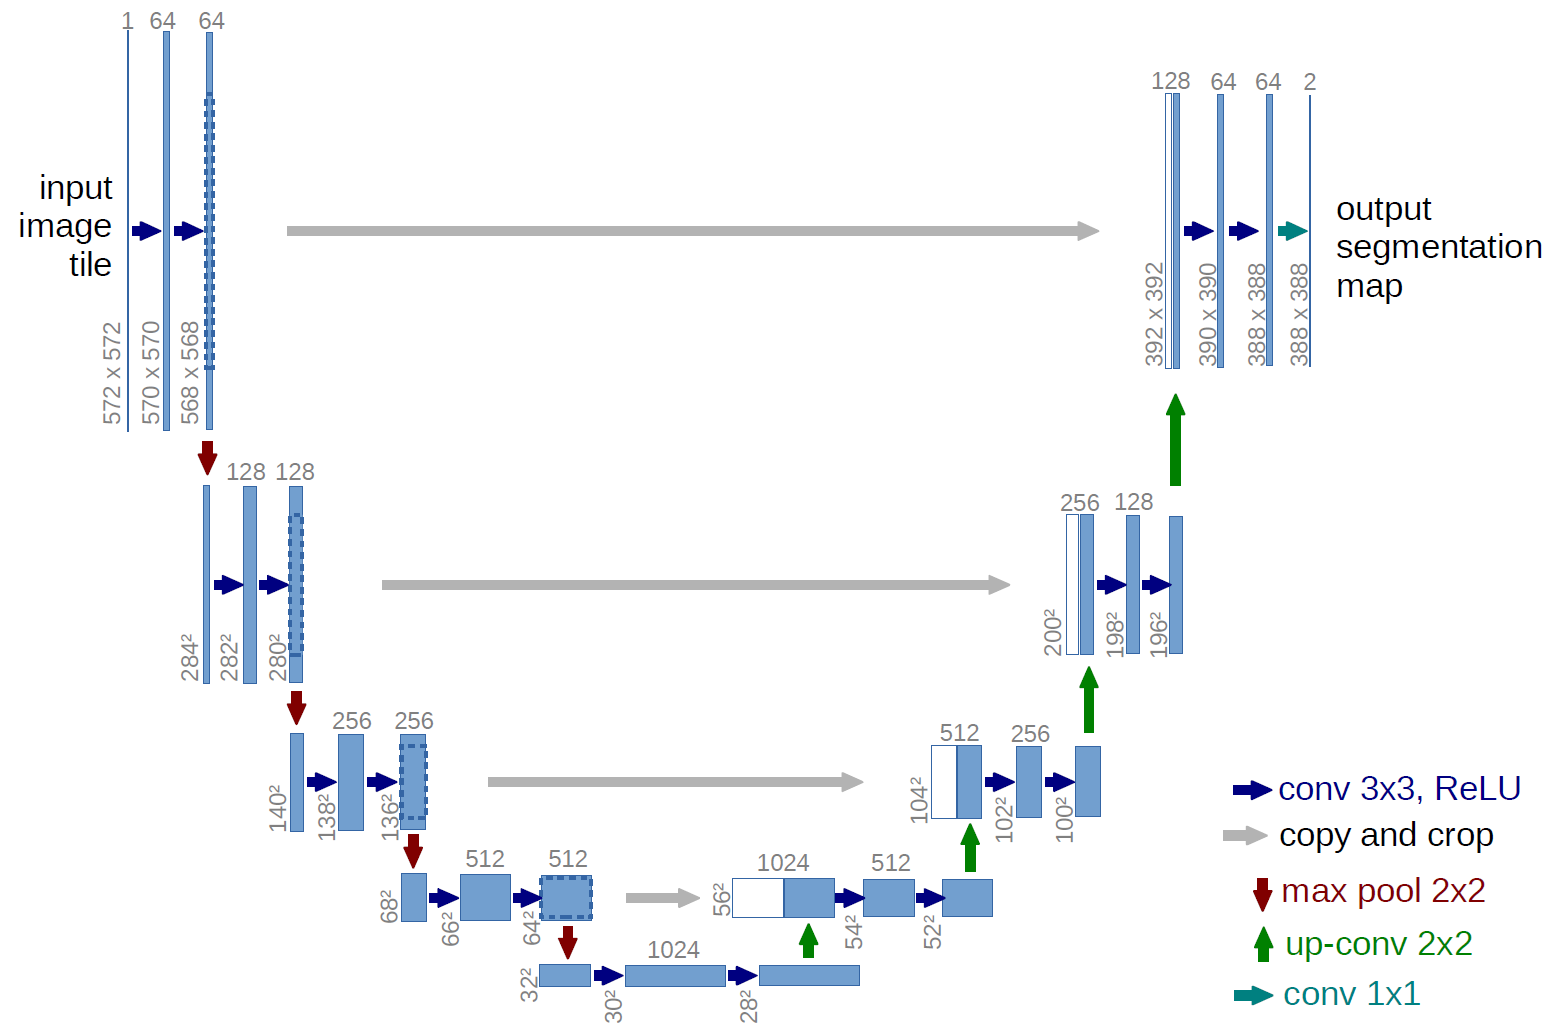

In [ ]:
# UNET -- Model Architecture

In [ ]:
# RUN

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

def ssim_loss(y_true, y_pred):
    """Calculate SSIM (structural similarity) loss.
      Args: y_true (tensor), y_pred (tensor)
      Returns: float SSIM loss value (1 - SSIM mean)
    """
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred):
    """Combined loss including SSIM and MSE for balanced optimization.
      Args: y_true (tensor), y_pred (tensor)
      Returns: float weighted loss value
    """
    ssim = ssim_loss(y_true, y_pred)
    mse = tf.keras.losses.mse(y_true, y_pred)
    return 0.7 * ssim + 0.3 * mse

def edge_preservation_loss(y_true, y_pred):
    """
    Compute edge preservation loss using Sobel edge detection.
    Args: y_true (tensor), y_pred (tensor)
    Returns: float edge preservation loss value
    """
    edge_true = tf.image.sobel_edges(y_true)
    edge_pred = tf.image.sobel_edges(y_pred)
    return tf.reduce_mean(tf.abs(edge_true - edge_pred))

def document_focused_loss(y_true, y_pred):
    """
    Combine SSIM, edge preservation, and MSE losses to focus on document structure and accuracy.
    Args: y_true (tensor), y_pred (tensor)
    Returns: float weighted loss value
    """
    ssim_score = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0)) # ssim_loss(y_true, y_pred)
    edge_score = edge_preservation_loss(y_true, y_pred)
    mse_score = tf.keras.losses.mse(y_true, y_pred)

    return 0.6 * ssim_score + 0.3 * edge_score + 0.1 * mse_score

def ResidualBlock(width):
    """
    Create a residual block for convolutional layers with a specified num of filters(width),
    maintaining or adjusting dimensions.
    Args: width (int): Number of filters in the convolutional layers.
    Returns: tensor: Output tensor after applying the residual block.
    """

    def apply(x):
        """Apply a residual block to the input tensor"""
        input_width = K.int_shape(x)[-1]

        if input_width == width: # Adjust residual connection dimensions if necessary
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)

        # Apply batch normalization and convolutions
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual]) # Add residual connection
        return x
    return apply

def DownBlock(width, block_depth):
    """
    Create a downsampling block with residual connections and average pooling.
    Args:     width (int): Number of filters for each residual block.
              block_depth (int): Number of residual blocks in the downsampling block.
    Returns:  tensor: Output tensor after downsampling.
    """
    def apply(x):
        """
        Apply the downsampling block to the input tensor.
        Args:       x (tuple): A tuple (input tensor, skip connections list).
        Returns:    tensor: Output tensor after downsampling.
        """
        x, skips = x # Unpack input tensor and skip connections list

        for _ in range(block_depth): # Apply residual blocks and store skip connections
            x = ResidualBlock(width)(x)
            skips.append(x)

        x = layers.AveragePooling2D(pool_size=2)(x) # Downsample using average pooling
        return x
    return apply

def UpBlock(width, block_depth):
    """
    Create an upsampling block with skip connections and residual blocks.
    Args:    width (int): Number of filters for each residual block.
             block_depth (int): Number of residual blocks in the upsampling block.
    Returns: tensor: Output tensor after upsampling and residual processing.
    """
    def apply(x):
        """
        Apply the upsampling block to the input tensor.
        Args:        x (tuple): A tuple (input tensor, skip connections list).
        Returns:     tensor: Output tensor after upsampling and residual processing.
        """
        x, skips = x # Unpack input tensor and skip connections list

        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x) # Upsample input tensor

        # Add skip connections and residual blocks
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])  # Merge with skip connection
            x = ResidualBlock(width)(x) # Apply residual block
        return x
    return apply

def get_network(image_size=512, widths=[32, 64, 96], block_depth=2, is_gray=True):
    """
    Builds the Residual U-Net model for image denoising by setting up all of Residual, Up and Down blocks.
    Args:     image_size (int): Size of input image (assumed square). Default is 512.
              widths (list of int): Widths (number of filters) for each block in the encoder/decoder.
              block_depth (int): Number of residual blocks per down/up sampling block. Default is 2.
              is_gray (bool): Whether the input/output images are grayscale. Default is True.
    Returns:  Model: A compiled Keras model.
    """
    # Set number of input/output channels
    input_channels = 1 if is_gray else 3
    output_channels = 1 if is_gray else 3

    # Input layer for noisy images
    noisy_images = layers.Input(shape=(image_size, image_size, input_channels))

    # Initial convolution
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    skips = [] # Store skip connections

    # Encoder path
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips]) # Downsampling block

    # Middle residual blocks
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x) # Process with residual blocks

    # Decoder path
    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips]) # Upsampling block with skip connections from corresponding Downsampling blocks

    # Final convolution to produce output
    x = layers.Conv2D(output_channels, kernel_size=1, kernel_initializer="zeros")(x)

    # Define model and compile with optimizer, loss and metrics
    model = Model(inputs=noisy_images, outputs=x, name="residual_unet")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss=document_focused_loss, # Custom loss function
                 metrics=['mae']) # Mean Absolute Error as metric

    return model


# Create model
model = get_network(widths=[32, 48, 64, 128, 160], is_gray=True)
model.summary()

Model: "residual_unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 512, 512, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 512, 512, 32)   │             64 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 512, 512, 32)   │             64 │ conv2d_100[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 512, 512, 32)   │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 512, 512, 32)   │          9,248 │ conv2d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_36 (Add)              │ (None, 512, 512, 32)   │              0 │ conv2d_102[0][0],      │
│                           │                        │                │ conv2d_100[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 512, 512, 32)   │             64 │ add_36[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 512, 512, 32)   │          9,248 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 512, 512, 32)   │          9,248 │ conv2d_103[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_37 (Add)              │ (None, 512, 512, 32)   │              0 │ conv2d_104[0][0],      │
│                           │                        │                │ add_36[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_8       │ (None, 256, 256, 32)   │              0 │ add_37[0][0]           │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 256, 256, 32)   │             64 │ average_pooling2d_8[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 256, 256, 48)   │         13,872 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 256, 256, 48)   │         20,784 │ conv2d_106[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_105 (Conv2D)       │ (None, 256, 256, 48)   │          1,584 │ average_pooling2d_8[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_38 (Add)              │ (None, 256, 256, 48)   │              0 │ conv2d_107[0][0],      │
│                      

 Total params: 3,159,377 (12.05 MB)

 Trainable params: 3,155,473 (12.04 MB)

 Non-trainable params: 3,904 (15.25 KB)

training ####

In [ ]:
# Callbacks

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
import os


# save the best model based on validation image loss
model_num = len(os.listdir(f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models'))
os.makedirs(f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models_final', exist_ok=True)
checkpoint_path = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v{model_num}BBBBB.weights.h5'


class SaveCallback(keras.callbacks.Callback):
    """Custom callback to log metrics at the end of each epoch."""

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch} logs: {logs}\n")  # See what metrics are available

# save_callback = SaveCallback()

class GradientClippingCallback(keras.callbacks.Callback):
    """Custom callback to apply gradient clipping at the start of each training batch."""

    def on_train_batch_begin(self, batch, logs=None):
        self.model.optimizer.clip_norm = 1.0

# gradient_clipping_callback = GradientClippingCallback()

class PlottingCallback(keras.callbacks.Callback):
    """Custom callback to plot images at the end of every 10th epoch."""

    def on_epoch_end(self, epoch, logs=None):
        # Check if the epoch is a multiple of 10
        if (epoch + 1) % 10 == 0:  # +1 because epoch indexing starts at 0
            self.model.plot_images(epoch, logs)

# plotting_callback = PlottingCallback()

class EarlyStoppingCallback(EarlyStopping):
    """Extends EarlyStopping to add logging when training stops due to no improvement."""

    def __init__(self, monitor='val_kid', min_delta=0, patience=30, verbose=1, mode='min', baseline=None, restore_best_weights=True):

        super().__init__( monitor=monitor, min_delta=min_delta,
                          patience=patience, verbose=verbose,
                          mode=mode, baseline=baseline, restore_best_weights=restore_best_weights )


    def on_epoch_end(self, epoch, logs=None):
        # Call the parent class's on_epoch_end method
        super().on_epoch_end(epoch, logs)

        # You can add custom logic here if needed
        if self.stopped_epoch > 0:
            print(f"\nTraining stopped at epoch {epoch + 1} due to no improvement in {self.monitor}")
            print(f"Best value of {self.monitor}: {self.best}")

# early_stopping_callback = EarlyStoppingCallback()

# Create custom pruning callback
class PruningCallback(tf.keras.callbacks.Callback):
    """Callback to integrate Optuna pruning based on a monitored metric."""

    def __init__(self, trial, monitor="val_kid"):
        super().__init__()
        self.trial = trial
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        """Initializes the callback with the Optuna trial and metric to monitor."""

        current_score = logs.get(self.monitor)
        # Check for numerical instability
        if current_score is not None and (np.isnan(current_score) or np.isinf(current_score)):
            raise optuna.TrialPruned("Trial pruned due to numerical instability")

        if current_score is not None:
            self.trial.report(current_score, epoch)
            if self.trial.should_prune():
                raise optuna.TrialPruned()

# pruning_callback = PruningCallback(trial)


class MetricsCallback(keras.callbacks.Callback):
    """Custom callback to display formatted training and validation metrics at the end of each epoch."""

    def on_epoch_end(self, epoch, logs=None):
        """Formats and prints metrics for the current epoch."""

        logs = logs or {}
        epoch_str = f"Epoch {epoch+1}/{self.params['epochs']}"
        steps_str = f"{self.params['steps']}/{self.params['steps']} "
        progress = "━" * 20

        # Format main metrics line
        metrics_1 = (f"{steps_str}{progress} "
                    f"3s 44ms/step - "
                    f"i_loss: {logs.get('i_loss', 0):.4f} - "
                    f"n_loss: {logs.get('n_loss', 0):.4f}")

        # Format validation metrics line with matching indentation
        metrics_2 = (" " * len(f"{steps_str}{progress} 3s 44ms/step") +  # Match indentation
                    f" - val_i_loss: {logs.get('val_i_loss', 0):.4f} - "
                    f"val_n_loss: {logs.get('val_n_loss', 0):.4f} - "
                    f"val_image_loss: {logs.get('val_image_loss', 0):.4f} - "
                    f"val_KID: {logs.get('val_kid', 0):.4e}")

        print(f"\r{epoch_str}")
        print(f"{metrics_1}")
        print(f"{metrics_2}")

# metrics_callback = MetricsCallback()


class OptimizerWithMixedPrecision:
    """Custom optimizer with mixed precision and configurable learning rate, weight decay, and gradient clipping."""

    def __init__(self, learning_rate, weight_decay, num_epochs, dataset_length, clipnorm=1.0):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.dataset_length = dataset_length
        self.clipnorm = clipnorm

    def get_optimizer(self):
        """Creates a mixed precision optimizer with cosine decay learning rate schedule."""

        base_optimizer = keras.optimizers.AdamW(
            learning_rate=keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=self.learning_rate,
                decay_steps=self.num_epochs * self.dataset_length
            ),
            weight_decay=self.weight_decay,
            clipnorm=self.clipnorm
        )
        return mixed_precision.LossScaleOptimizer(base_optimizer)


# optimizer_creator = OptimizerWithMixedPrecision(  learning_rate=learning_rate,
#                                                   weight_decay=weight_decay,
#                                                   num_epochs=num_epochs,
#                                                   dataset_length=len(train_dataset),
#                                                   clipnorm=1.0)

# optimizer = optimizer_creator.get_optimizer()

class CustomReduceLROnPlateau(keras.callbacks.ReduceLROnPlateau):
    """Extends ReduceLROnPlateau to customize learning rate reduction based on a monitored metric."""

    def __init__(self,
                 monitor='val_kid',
                 factor=0.2,
                 patience=15,
                 min_lr=1e-7,
                 verbose=1,
                 mode='min',
                 min_delta=0,
                 cooldown=0):
        super().__init__(
            monitor=monitor,
            factor=factor,
            patience=patience,
            min_lr=min_lr,
            verbose=verbose,
            mode=mode,
            min_delta=min_delta,
            cooldown=cooldown
        )

# reduce_lr_callback = CustomReduceLROnPlateau()

class CustomModelCheckpoint(keras.callbacks.ModelCheckpoint):
    """Extends ModelCheckpoint to customize model saving based on a monitored metric."""

    def __init__(self,
                 filepath,
                 monitor='val_loss',
                 mode='min',
                 save_weights_only=True,
                 save_best_only=True,
                 verbose=1):
        super().__init__(
            filepath=filepath,
            monitor=monitor,
            mode=mode,
            save_weights_only=save_weights_only,
            save_best_only=save_best_only,
            verbose=verbose
        )

# # Usage:
# checkpoint = CustomModelCheckpoint(filepath=checkpoint_path)


import psutil
class MemoryCallback(tf.keras.callbacks.Callback):
    """Callback to monitor memory usage and clear resources during training."""

    def __init__(self, threshold_mb=1000):
        super().__init__()
        self.threshold_mb = threshold_mb

    def on_batch_end(self, batch, logs=None):
        """Monitor memory usage at the end of each batch and clears memory if it exceeds the threshold."""

        # Clear memory if usage exceeds threshold
        memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
        if memory_usage > self.threshold_mb:
            gc.collect()
            tf.keras.backend.clear_session()

    def on_epoch_end(self, epoch, logs=None):
        """Forces cleanup of resources at the end of each epoch."""

        # Force cleanup between epochs
        gc.collect()
        tf.keras.backend.clear_session()


callbacks = [
    EarlyStoppingCallback(monitor='val_loss'),  # Changed from val_kid
    GradientClippingCallback(),
    CustomReduceLROnPlateau(monitor='val_loss'),  # Changed from val_kid
    CustomModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss'  # Changed from val_kid
    ),
    MemoryCallback(threshold_mb=1000)
]

In [ ]:
# TRAINING with the patches
# 6 hours for 100 epochs
# 0.03242 for Val loss

import gc
gc.collect()

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_num = 1 + len(os.listdir(denoising_autoencoder_pcx_dir))
model_checkpoint = ModelCheckpoint(
    filepath=f'{denoising_autoencoder_pcx_dir}/best_enhanced_autoencoder_v{model_num}XXXPPP.keras',
    monitor='val_loss',
    save_best_only=True
)

callbacks = [
        EarlyStoppingCallback(),
        GradientClippingCallback(),
        CustomReduceLROnPlateau(),
        CustomModelCheckpoint(filepath=checkpoint_path),
        # MemoryCallback(threshold_mb=1000)
    ]

# Training parameters
batch_size = 4
epochs = 100 #00

# Training with same parameters
history = model.fit(
    X_train_p, Y_train_p,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_p, Y_val_p),
    callbacks=callbacks, #[early_stopping, model_checkpoint],
    verbose=1
)

18

Epoch 1/100
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1346 - mae: 0.1062
Epoch 1: val_loss improved from inf to 0.09582, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_kid` which is not available. Available metrics are: loss,mae,val_loss,val_mae
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_kid` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


2364/2364 ━━━━━━━━━━━━━━━━━━━━ 263s 94ms/step - loss: 0.1346 - mae: 0.1062 - val_loss: 0.0958 - val_mae: 0.0763 - learning_rate: 1.0000e-04
Epoch 2/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0723 - mae: 0.0611
Epoch 2: val_loss improved from 0.09582 to 0.05634, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0723 - mae: 0.0611 - val_loss: 0.0563 - val_mae: 0.0393 - learning_rate: 1.0000e-04
Epoch 3/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0636 - mae: 0.0576
Epoch 3: val_loss improved from 0.05634 to 0.05533, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0636

#### Learning curve from training log

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss')

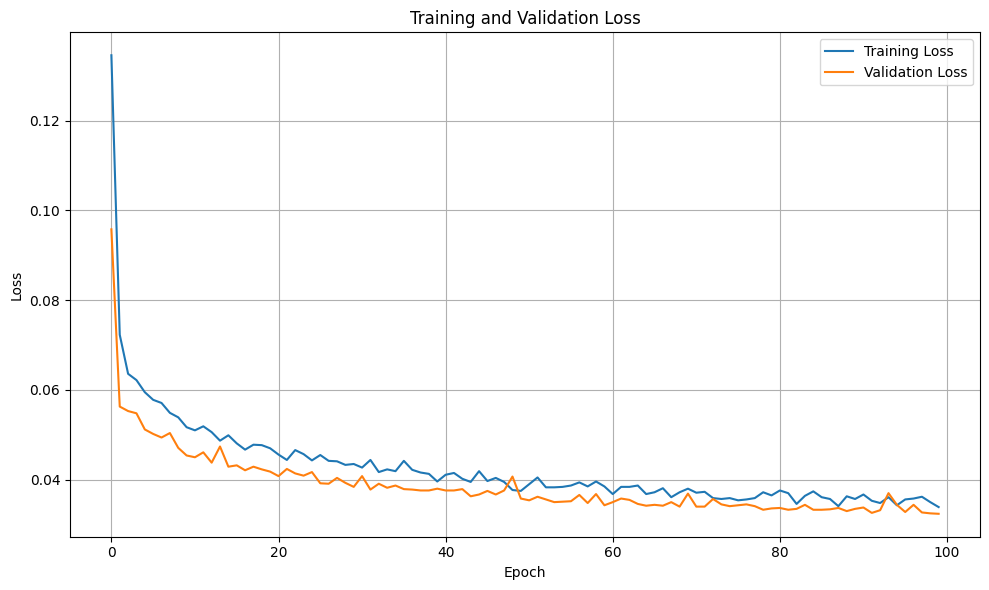

Final training loss: 0.0339
Final validation loss: 0.0324


In [ ]:
training_log = """18
Epoch 1/100
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1346 - mae: 0.1062
Epoch 1: val_loss improved from inf to 0.09582, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_kid` which is not available. Available metrics are: loss,mae,val_loss,val_mae
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_kid` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 263s 94ms/step - loss: 0.1346 - mae: 0.1062 - val_loss: 0.0958 - val_mae: 0.0763 - learning_rate: 1.0000e-04
Epoch 2/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0723 - mae: 0.0611
Epoch 2: val_loss improved from 0.09582 to 0.05634, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0723 - mae: 0.0611 - val_loss: 0.0563 - val_mae: 0.0393 - learning_rate: 1.0000e-04
Epoch 3/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0636 - mae: 0.0576
Epoch 3: val_loss improved from 0.05634 to 0.05533, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0636 - mae: 0.0576 - val_loss: 0.0553 - val_mae: 0.0437 - learning_rate: 1.0000e-04
Epoch 4/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0622 - mae: 0.0553
Epoch 4: val_loss improved from 0.05533 to 0.05475, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0622 - mae: 0.0553 - val_loss: 0.0548 - val_mae: 0.0665 - learning_rate: 1.0000e-04
Epoch 5/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0595 - mae: 0.0555
Epoch 5: val_loss improved from 0.05475 to 0.05125, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0595 - mae: 0.0555 - val_loss: 0.0512 - val_mae: 0.0585 - learning_rate: 1.0000e-04
Epoch 6/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0578 - mae: 0.0518
Epoch 6: val_loss improved from 0.05125 to 0.05024, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0578 - mae: 0.0518 - val_loss: 0.0502 - val_mae: 0.0330 - learning_rate: 1.0000e-04
Epoch 7/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0571 - mae: 0.0542
Epoch 7: val_loss improved from 0.05024 to 0.04943, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0571 - mae: 0.0542 - val_loss: 0.0494 - val_mae: 0.0607 - learning_rate: 1.0000e-04
Epoch 8/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0549 - mae: 0.0536
Epoch 8: val_loss did not improve from 0.04943
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0549 - mae: 0.0536 - val_loss: 0.0504 - val_mae: 0.0461 - learning_rate: 1.0000e-04
Epoch 9/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0539 - mae: 0.0509
Epoch 9: val_loss improved from 0.04943 to 0.04711, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0539 - mae: 0.0509 - val_loss: 0.0471 - val_mae: 0.0271 - learning_rate: 1.0000e-04
Epoch 10/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0517 - mae: 0.0488
Epoch 10: val_loss improved from 0.04711 to 0.04539, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0517 - mae: 0.0488 - val_loss: 0.0454 - val_mae: 0.0461 - learning_rate: 1.0000e-04
Epoch 11/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0510 - mae: 0.0472
Epoch 11: val_loss improved from 0.04539 to 0.04497, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0510 - mae: 0.0472 - val_loss: 0.0450 - val_mae: 0.0336 - learning_rate: 1.0000e-04
Epoch 12/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0519 - mae: 0.0459
Epoch 12: val_loss did not improve from 0.04497
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0519 - mae: 0.0459 - val_loss: 0.0461 - val_mae: 0.0281 - learning_rate: 1.0000e-04
Epoch 13/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0506 - mae: 0.0435
Epoch 13: val_loss improved from 0.04497 to 0.04376, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0506 - mae: 0.0435 - val_loss: 0.0438 - val_mae: 0.0361 - learning_rate: 1.0000e-04
Epoch 14/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0487 - mae: 0.0427
Epoch 14: val_loss did not improve from 0.04376
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - loss: 0.0487 - mae: 0.0427 - val_loss: 0.0474 - val_mae: 0.0368 - learning_rate: 1.0000e-04
Epoch 15/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0499 - mae: 0.0432
Epoch 15: val_loss improved from 0.04376 to 0.04286, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0499 - mae: 0.0432 - val_loss: 0.0429 - val_mae: 0.0262 - learning_rate: 1.0000e-04
Epoch 16/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0481 - mae: 0.0400
Epoch 16: val_loss did not improve from 0.04286
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - loss: 0.0481 - mae: 0.0400 - val_loss: 0.0432 - val_mae: 0.0504 - learning_rate: 1.0000e-04
Epoch 17/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0467 - mae: 0.0407
Epoch 17: val_loss improved from 0.04286 to 0.04215, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0467 - mae: 0.0407 - val_loss: 0.0421 - val_mae: 0.0254 - learning_rate: 1.0000e-04
Epoch 18/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0478 - mae: 0.0419
Epoch 18: val_loss did not improve from 0.04215
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - loss: 0.0478 - mae: 0.0419 - val_loss: 0.0429 - val_mae: 0.0253 - learning_rate: 1.0000e-04
Epoch 19/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0477 - mae: 0.0424
Epoch 19: val_loss did not improve from 0.04215
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - loss: 0.0477 - mae: 0.0424 - val_loss: 0.0423 - val_mae: 0.0199 - learning_rate: 1.0000e-04
Epoch 20/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0470 - mae: 0.0406
Epoch 20: val_loss improved from 0.04215 to 0.04181, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0470 - mae: 0.0406 - val_loss: 0.0418 - val_mae: 0.0220 - learning_rate: 1.0000e-04
Epoch 21/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0456 - mae: 0.0403
Epoch 21: val_loss improved from 0.04181 to 0.04081, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0456 - mae: 0.0403 - val_loss: 0.0408 - val_mae: 0.0301 - learning_rate: 1.0000e-04
Epoch 22/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0444 - mae: 0.0393
Epoch 22: val_loss did not improve from 0.04081
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0444 - mae: 0.0393 - val_loss: 0.0424 - val_mae: 0.0259 - learning_rate: 1.0000e-04
Epoch 23/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0466 - mae: 0.0414
Epoch 23: val_loss did not improve from 0.04081
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0466 - mae: 0.0414 - val_loss: 0.0414 - val_mae: 0.0431 - learning_rate: 1.0000e-04
Epoch 24/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0457 - mae: 0.0379
Epoch 24: val_loss did not improve from 0.04081
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0457 - mae: 0.0379 - val_loss: 0.0409 - val_mae: 0.0441 - learning_rate: 1.0000e-04
Epoch 25/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0443 - mae: 0.0391
Epoch 25: val_loss did not improve from 0.04081
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - loss: 0.0443 - mae: 0.0391 - val_loss: 0.0417 - val_mae: 0.0291 - learning_rate: 1.0000e-04
Epoch 26/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0455 - mae: 0.0378
Epoch 26: val_loss improved from 0.04081 to 0.03923, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0455 - mae: 0.0378 - val_loss: 0.0392 - val_mae: 0.0256 - learning_rate: 1.0000e-04
Epoch 27/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0442 - mae: 0.0381
Epoch 27: val_loss improved from 0.03923 to 0.03912, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0442 - mae: 0.0381 - val_loss: 0.0391 - val_mae: 0.0219 - learning_rate: 1.0000e-04
Epoch 28/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0441 - mae: 0.0357
Epoch 28: val_loss did not improve from 0.03912
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0441 - mae: 0.0357 - val_loss: 0.0404 - val_mae: 0.0342 - learning_rate: 1.0000e-04
Epoch 29/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0433 - mae: 0.0366
Epoch 29: val_loss did not improve from 0.03912
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0433 - mae: 0.0366 - val_loss: 0.0393 - val_mae: 0.0283 - learning_rate: 1.0000e-04
Epoch 30/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0435 - mae: 0.0377
Epoch 30: val_loss improved from 0.03912 to 0.03845, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0435 - mae: 0.0377 - val_loss: 0.0384 - val_mae: 0.0298 - learning_rate: 1.0000e-04
Epoch 31/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0427 - mae: 0.0374
Epoch 31: val_loss did not improve from 0.03845
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 202s 85ms/step - loss: 0.0427 - mae: 0.0374 - val_loss: 0.0408 - val_mae: 0.0390 - learning_rate: 1.0000e-04
Epoch 32/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0444 - mae: 0.0382
Epoch 32: val_loss improved from 0.03845 to 0.03778, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 203s 86ms/step - loss: 0.0444 - mae: 0.0382 - val_loss: 0.0378 - val_mae: 0.0176 - learning_rate: 1.0000e-04
Epoch 33/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0417 - mae: 0.0351
Epoch 33: val_loss did not improve from 0.03778
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0417 - mae: 0.0351 - val_loss: 0.0391 - val_mae: 0.0319 - learning_rate: 1.0000e-04
Epoch 34/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0423 - mae: 0.0383
Epoch 34: val_loss did not improve from 0.03778
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - loss: 0.0423 - mae: 0.0383 - val_loss: 0.0382 - val_mae: 0.0317 - learning_rate: 1.0000e-04
Epoch 35/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0419 - mae: 0.0340
Epoch 35: val_loss did not improve from 0.03778
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0419 - mae: 0.0340 - val_loss: 0.0387 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 36/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0442 - mae: 0.0360
Epoch 36: val_loss did not improve from 0.03778
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0442 - mae: 0.0360 - val_loss: 0.0379 - val_mae: 0.0333 - learning_rate: 1.0000e-04
Epoch 37/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0422 - mae: 0.0368
Epoch 37: val_loss improved from 0.03778 to 0.03776, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0422 - mae: 0.0368 - val_loss: 0.0378 - val_mae: 0.0234 - learning_rate: 1.0000e-04
Epoch 38/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0416 - mae: 0.0364
Epoch 38: val_loss improved from 0.03776 to 0.03760, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0416 - mae: 0.0364 - val_loss: 0.0376 - val_mae: 0.0166 - learning_rate: 1.0000e-04
Epoch 39/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0413 - mae: 0.0353
Epoch 39: val_loss improved from 0.03760 to 0.03759, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0413 - mae: 0.0353 - val_loss: 0.0376 - val_mae: 0.0208 - learning_rate: 1.0000e-04
Epoch 40/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0396 - mae: 0.0347
Epoch 40: val_loss did not improve from 0.03759
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0396 - mae: 0.0347 - val_loss: 0.0380 - val_mae: 0.0303 - learning_rate: 1.0000e-04
Epoch 41/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0411 - mae: 0.0381
Epoch 41: val_loss improved from 0.03759 to 0.03757, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0411 - mae: 0.0381 - val_loss: 0.0376 - val_mae: 0.0326 - learning_rate: 1.0000e-04
Epoch 42/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0415 - mae: 0.0350
Epoch 42: val_loss improved from 0.03757 to 0.03755, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0415 - mae: 0.0350 - val_loss: 0.0376 - val_mae: 0.0194 - learning_rate: 1.0000e-04
Epoch 43/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0402 - mae: 0.0335
Epoch 43: val_loss did not improve from 0.03755
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0402 - mae: 0.0335 - val_loss: 0.0379 - val_mae: 0.0284 - learning_rate: 1.0000e-04
Epoch 44/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0395 - mae: 0.0337
Epoch 44: val_loss improved from 0.03755 to 0.03631, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0395 - mae: 0.0337 - val_loss: 0.0363 - val_mae: 0.0215 - learning_rate: 1.0000e-04
Epoch 45/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0419 - mae: 0.0348
Epoch 45: val_loss did not improve from 0.03631
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0419 - mae: 0.0348 - val_loss: 0.0367 - val_mae: 0.0191 - learning_rate: 1.0000e-04
Epoch 46/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0397 - mae: 0.0335
Epoch 46: val_loss did not improve from 0.03631
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0397 - mae: 0.0335 - val_loss: 0.0375 - val_mae: 0.0240 - learning_rate: 1.0000e-04
Epoch 47/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0404 - mae: 0.0349
Epoch 47: val_loss did not improve from 0.03631
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0404 - mae: 0.0349 - val_loss: 0.0367 - val_mae: 0.0269 - learning_rate: 1.0000e-04
Epoch 48/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0395 - mae: 0.0334
Epoch 48: val_loss did not improve from 0.03631
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 85ms/step - loss: 0.0395 - mae: 0.0334 - val_loss: 0.0376 - val_mae: 0.0213 - learning_rate: 1.0000e-04
Epoch 49/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0377 - mae: 0.0331
Epoch 49: val_loss did not improve from 0.03631
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0377 - mae: 0.0331 - val_loss: 0.0407 - val_mae: 0.0322 - learning_rate: 1.0000e-04
Epoch 50/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0375 - mae: 0.0335
Epoch 50: val_loss improved from 0.03631 to 0.03576, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0375 - mae: 0.0335 - val_loss: 0.0358 - val_mae: 0.0194 - learning_rate: 1.0000e-04
Epoch 51/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0390 - mae: 0.0352
Epoch 51: val_loss improved from 0.03576 to 0.03537, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0390 - mae: 0.0352 - val_loss: 0.0354 - val_mae: 0.0159 - learning_rate: 1.0000e-04
Epoch 52/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0405 - mae: 0.0335
Epoch 52: val_loss did not improve from 0.03537
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 196s 83ms/step - loss: 0.0405 - mae: 0.0335 - val_loss: 0.0362 - val_mae: 0.0246 - learning_rate: 1.0000e-04
Epoch 53/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0383 - mae: 0.0341
Epoch 53: val_loss did not improve from 0.03537
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0383 - mae: 0.0341 - val_loss: 0.0356 - val_mae: 0.0214 - learning_rate: 1.0000e-04
Epoch 54/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0383 - mae: 0.0337
Epoch 54: val_loss improved from 0.03537 to 0.03497, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0383 - mae: 0.0337 - val_loss: 0.0350 - val_mae: 0.0165 - learning_rate: 1.0000e-04
Epoch 55/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0384 - mae: 0.0326
Epoch 55: val_loss did not improve from 0.03497
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0384 - mae: 0.0326 - val_loss: 0.0351 - val_mae: 0.0287 - learning_rate: 1.0000e-04
Epoch 56/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0387 - mae: 0.0336
Epoch 56: val_loss did not improve from 0.03497
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0387 - mae: 0.0336 - val_loss: 0.0352 - val_mae: 0.0171 - learning_rate: 1.0000e-04
Epoch 57/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0394 - mae: 0.0340
Epoch 57: val_loss did not improve from 0.03497
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 197s 83ms/step - loss: 0.0394 - mae: 0.0340 - val_loss: 0.0366 - val_mae: 0.0413 - learning_rate: 1.0000e-04
Epoch 58/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0385 - mae: 0.0344
Epoch 58: val_loss improved from 0.03497 to 0.03479, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0385 - mae: 0.0344 - val_loss: 0.0348 - val_mae: 0.0250 - learning_rate: 1.0000e-04
Epoch 59/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0396 - mae: 0.0339
Epoch 59: val_loss did not improve from 0.03479
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0396 - mae: 0.0339 - val_loss: 0.0368 - val_mae: 0.0265 - learning_rate: 1.0000e-04
Epoch 60/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0385 - mae: 0.0338
Epoch 60: val_loss improved from 0.03479 to 0.03432, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0385 - mae: 0.0338 - val_loss: 0.0343 - val_mae: 0.0198 - learning_rate: 1.0000e-04
Epoch 61/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0368 - mae: 0.0332
Epoch 61: val_loss did not improve from 0.03432
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0368 - mae: 0.0332 - val_loss: 0.0350 - val_mae: 0.0200 - learning_rate: 1.0000e-04
Epoch 62/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0384 - mae: 0.0334
Epoch 62: val_loss did not improve from 0.03432
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0384 - mae: 0.0334 - val_loss: 0.0358 - val_mae: 0.0166 - learning_rate: 1.0000e-04
Epoch 63/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0384 - mae: 0.0347
Epoch 63: val_loss did not improve from 0.03432
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0384 - mae: 0.0347 - val_loss: 0.0355 - val_mae: 0.0279 - learning_rate: 1.0000e-04
Epoch 64/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0387 - mae: 0.0349
Epoch 64: val_loss did not improve from 0.03432
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0387 - mae: 0.0349 - val_loss: 0.0346 - val_mae: 0.0201 - learning_rate: 1.0000e-04
Epoch 65/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0368 - mae: 0.0323
Epoch 65: val_loss improved from 0.03432 to 0.03423, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 85ms/step - loss: 0.0368 - mae: 0.0323 - val_loss: 0.0342 - val_mae: 0.0163 - learning_rate: 1.0000e-04
Epoch 66/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0372 - mae: 0.0310
Epoch 66: val_loss did not improve from 0.03423
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0372 - mae: 0.0310 - val_loss: 0.0344 - val_mae: 0.0182 - learning_rate: 1.0000e-04
Epoch 67/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0381 - mae: 0.0324
Epoch 67: val_loss improved from 0.03423 to 0.03418, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0381 - mae: 0.0324 - val_loss: 0.0342 - val_mae: 0.0194 - learning_rate: 1.0000e-04
Epoch 68/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0361 - mae: 0.0313
Epoch 68: val_loss did not improve from 0.03418
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0361 - mae: 0.0313 - val_loss: 0.0350 - val_mae: 0.0187 - learning_rate: 1.0000e-04
Epoch 69/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0372 - mae: 0.0314
Epoch 69: val_loss improved from 0.03418 to 0.03403, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0372 - mae: 0.0314 - val_loss: 0.0340 - val_mae: 0.0236 - learning_rate: 1.0000e-04
Epoch 70/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0380 - mae: 0.0320
Epoch 70: val_loss did not improve from 0.03403
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0380 - mae: 0.0320 - val_loss: 0.0369 - val_mae: 0.0438 - learning_rate: 1.0000e-04
Epoch 71/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0371 - mae: 0.0323
Epoch 71: val_loss did not improve from 0.03403
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0371 - mae: 0.0323 - val_loss: 0.0340 - val_mae: 0.0215 - learning_rate: 1.0000e-04
Epoch 72/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0373 - mae: 0.0318
Epoch 72: val_loss improved from 0.03403 to 0.03397, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0373 - mae: 0.0318 - val_loss: 0.0340 - val_mae: 0.0175 - learning_rate: 1.0000e-04
Epoch 73/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0359 - mae: 0.0308
Epoch 73: val_loss did not improve from 0.03397
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0359 - mae: 0.0308 - val_loss: 0.0357 - val_mae: 0.0400 - learning_rate: 1.0000e-04
Epoch 74/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0357 - mae: 0.0315
Epoch 74: val_loss did not improve from 0.03397
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0357 - mae: 0.0315 - val_loss: 0.0345 - val_mae: 0.0206 - learning_rate: 1.0000e-04
Epoch 75/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0359 - mae: 0.0314
Epoch 75: val_loss did not improve from 0.03397
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0359 - mae: 0.0314 - val_loss: 0.0341 - val_mae: 0.0279 - learning_rate: 1.0000e-04
Epoch 76/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0354 - mae: 0.0297
Epoch 76: val_loss did not improve from 0.03397
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0354 - mae: 0.0297 - val_loss: 0.0343 - val_mae: 0.0176 - learning_rate: 1.0000e-04
Epoch 77/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0356 - mae: 0.0315
Epoch 77: val_loss did not improve from 0.03397
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0356 - mae: 0.0315 - val_loss: 0.0345 - val_mae: 0.0167 - learning_rate: 1.0000e-04
Epoch 78/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0359 - mae: 0.0303
Epoch 78: val_loss did not improve from 0.03397
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0359 - mae: 0.0304 - val_loss: 0.0341 - val_mae: 0.0267 - learning_rate: 1.0000e-04
Epoch 79/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0372 - mae: 0.0334
Epoch 79: val_loss improved from 0.03397 to 0.03335, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0372 - mae: 0.0333 - val_loss: 0.0333 - val_mae: 0.0210 - learning_rate: 1.0000e-04
Epoch 80/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0365 - mae: 0.0317
Epoch 80: val_loss did not improve from 0.03335
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0365 - mae: 0.0317 - val_loss: 0.0336 - val_mae: 0.0244 - learning_rate: 1.0000e-04
Epoch 81/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0376 - mae: 0.0325
Epoch 81: val_loss did not improve from 0.03335
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0376 - mae: 0.0325 - val_loss: 0.0337 - val_mae: 0.0237 - learning_rate: 1.0000e-04
Epoch 82/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0370 - mae: 0.0326
Epoch 82: val_loss improved from 0.03335 to 0.03329, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0370 - mae: 0.0326 - val_loss: 0.0333 - val_mae: 0.0193 - learning_rate: 1.0000e-04
Epoch 83/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0346 - mae: 0.0307
Epoch 83: val_loss did not improve from 0.03329
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0346 - mae: 0.0307 - val_loss: 0.0335 - val_mae: 0.0162 - learning_rate: 1.0000e-04
Epoch 84/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0364 - mae: 0.0305
Epoch 84: val_loss did not improve from 0.03329
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0364 - mae: 0.0305 - val_loss: 0.0344 - val_mae: 0.0376 - learning_rate: 1.0000e-04
Epoch 85/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0374 - mae: 0.0327
Epoch 85: val_loss did not improve from 0.03329
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0374 - mae: 0.0327 - val_loss: 0.0333 - val_mae: 0.0180 - learning_rate: 1.0000e-04
Epoch 86/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0361 - mae: 0.0307
Epoch 86: val_loss improved from 0.03329 to 0.03326, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0361 - mae: 0.0307 - val_loss: 0.0333 - val_mae: 0.0177 - learning_rate: 1.0000e-04
Epoch 87/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0357 - mae: 0.0298
Epoch 87: val_loss did not improve from 0.03326
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0357 - mae: 0.0298 - val_loss: 0.0334 - val_mae: 0.0300 - learning_rate: 1.0000e-04
Epoch 88/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0341 - mae: 0.0292
Epoch 88: val_loss did not improve from 0.03326
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0341 - mae: 0.0292 - val_loss: 0.0337 - val_mae: 0.0251 - learning_rate: 1.0000e-04
Epoch 89/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0363 - mae: 0.0319
Epoch 89: val_loss improved from 0.03326 to 0.03296, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0363 - mae: 0.0319 - val_loss: 0.0330 - val_mae: 0.0182 - learning_rate: 1.0000e-04
Epoch 90/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0357 - mae: 0.0311
Epoch 90: val_loss did not improve from 0.03296
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0357 - mae: 0.0311 - val_loss: 0.0335 - val_mae: 0.0274 - learning_rate: 1.0000e-04
Epoch 91/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0367 - mae: 0.0311
Epoch 91: val_loss did not improve from 0.03296
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0367 - mae: 0.0311 - val_loss: 0.0338 - val_mae: 0.0203 - learning_rate: 1.0000e-04
Epoch 92/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0353 - mae: 0.0297
Epoch 92: val_loss improved from 0.03296 to 0.03260, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 85ms/step - loss: 0.0353 - mae: 0.0297 - val_loss: 0.0326 - val_mae: 0.0181 - learning_rate: 1.0000e-04
Epoch 93/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0348 - mae: 0.0301
Epoch 93: val_loss did not improve from 0.03260
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0348 - mae: 0.0301 - val_loss: 0.0332 - val_mae: 0.0148 - learning_rate: 1.0000e-04
Epoch 94/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0361 - mae: 0.0299
Epoch 94: val_loss did not improve from 0.03260
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0361 - mae: 0.0299 - val_loss: 0.0370 - val_mae: 0.0207 - learning_rate: 1.0000e-04
Epoch 95/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0343 - mae: 0.0305
Epoch 95: val_loss did not improve from 0.03260
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0343 - mae: 0.0305 - val_loss: 0.0344 - val_mae: 0.0452 - learning_rate: 1.0000e-04
Epoch 96/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0356 - mae: 0.0308
Epoch 96: val_loss did not improve from 0.03260
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0356 - mae: 0.0308 - val_loss: 0.0328 - val_mae: 0.0168 - learning_rate: 1.0000e-04
Epoch 97/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0358 - mae: 0.0303
Epoch 97: val_loss did not improve from 0.03260
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 199s 84ms/step - loss: 0.0358 - mae: 0.0303 - val_loss: 0.0344 - val_mae: 0.0245 - learning_rate: 1.0000e-04
Epoch 98/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0362 - mae: 0.0305
Epoch 98: val_loss did not improve from 0.03260
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 198s 84ms/step - loss: 0.0362 - mae: 0.0305 - val_loss: 0.0327 - val_mae: 0.0251 - learning_rate: 1.0000e-04
Epoch 99/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0350 - mae: 0.0305
Epoch 99: val_loss improved from 0.03260 to 0.03248, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - loss: 0.0350 - mae: 0.0305 - val_loss: 0.0325 - val_mae: 0.0211 - learning_rate: 1.0000e-04
Epoch 100/100
2363/2364 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0339 - mae: 0.0284
Epoch 100: val_loss improved from 0.03248 to 0.03242, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5
2364/2364 ━━━━━━━━━━━━━━━━━━━━ 200s 85ms/step - loss: 0.0339 - mae: 0.0284 - val_loss: 0.0324 - val_mae: 0.0209 - learning_rate: 1.0000e-04 """


# import os, sys
# os._exit(0)
# sys.exit(0)


import pandas as pd
import matplotlib.pyplot as plt

# Extract metrics from training log
metrics = []
for line in training_log.split('\n'):
    if 'loss:' in line and 'val_loss:' in line:
        parts = line.split('-')
        values = {}
        for part in parts:
            if 'loss:' in part or 'mae:' in part or 'val_loss:' in part or 'val_mae:' in part:
                key, value = part.strip().split(':')
                values[key] = float(value)
        metrics.append(values)

# Convert to DataFrame
df = pd.DataFrame(metrics)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df['loss'], label='Training Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final training loss: {df['loss'].iloc[-1]:.4f}")
print(f"Final validation loss: {df['val_loss'].iloc[-1]:.4f}")

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Loss')

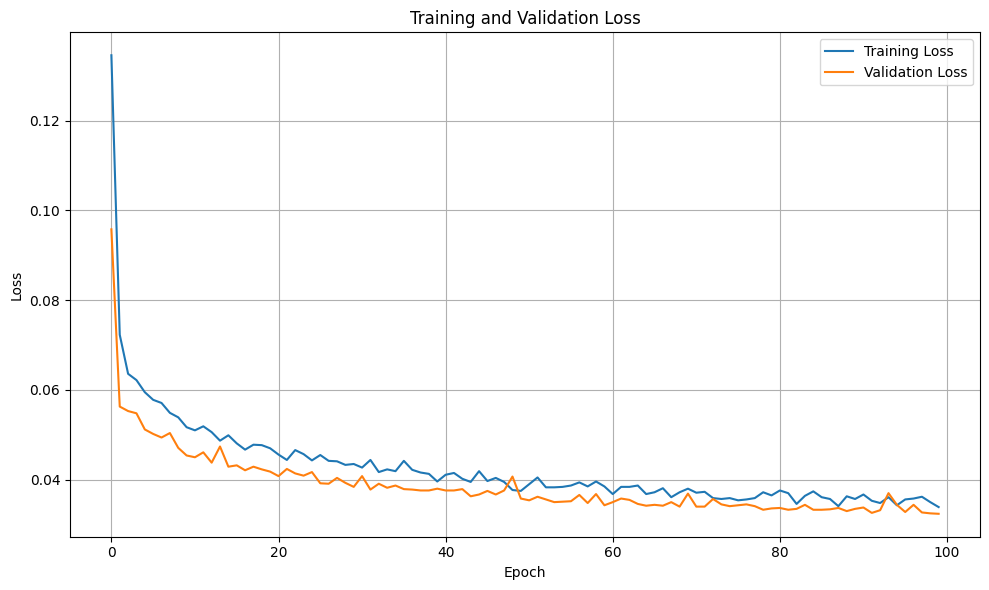

Final training loss: 0.0339
Final validation loss: 0.0324


### Inference

- Pick a large test image
- Get all 512×512 patches
- Make predictions on each patch
- Stitch all predicted patches together to reconstruct the prediction
- Display with Shabby and Clean (target) images


In [ ]:
# Patched Image shapes

image_patches = Path('../shabby01/image_patches/'); image_patches.mkdir(exist_ok=True)
cache_dir = Path('../shabby01/cache_patches'); cache_dir.mkdir(exist_ok=True)


print(f"Shape of X_train_p: {X_train_p.shape}")   # (9453, 512, 512, 1)
print(f"Shape of Y_train_p: {Y_train_p.shape}\n") # (9453, 512, 512, 1)


print(f"Shape of X_val_p: {X_val_p.shape}")       # (1636, 512, 512, 1)
print(f"Shape of Y_val_p: {Y_val_p.shape}\n")     # (1636, 512, 512, 1)


print(f"Shape of X_test_p: {X_test_p.shape}")     # (1636, 512, 512, 1)
print(f"Shape of Y_test_p: {Y_test_p.shape}\n")   # (1636, 512, 512, 1)


Shape of X_train_p: (9453, 512, 512, 1)
Shape of Y_train_p: (9453, 512, 512, 1)

Shape of X_val_p: (1636, 512, 512, 1)
Shape of Y_val_p: (1636, 512, 512, 1)

Shape of X_test_p: (1631, 512, 512, 1)
Shape of Y_test_p: (1631, 512, 512, 1)



In [ ]:

# Load the best model saved during training

model_path = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models_final/ddim_implicit_bb_v19BBBBB.weights.h5'

model = get_network(image_size=512,
                   widths=[32, 48, 64, 128, 160],
                   is_gray=True)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss=document_focused_loss,
             metrics=['mae'])

model.load_weights(model_path)

# Verify weights loaded
print(f"Model has {model.count_params()} parameters")


Model has 3159377 parameters


Processing image pair 553
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Processing image pair 1133
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Processing 

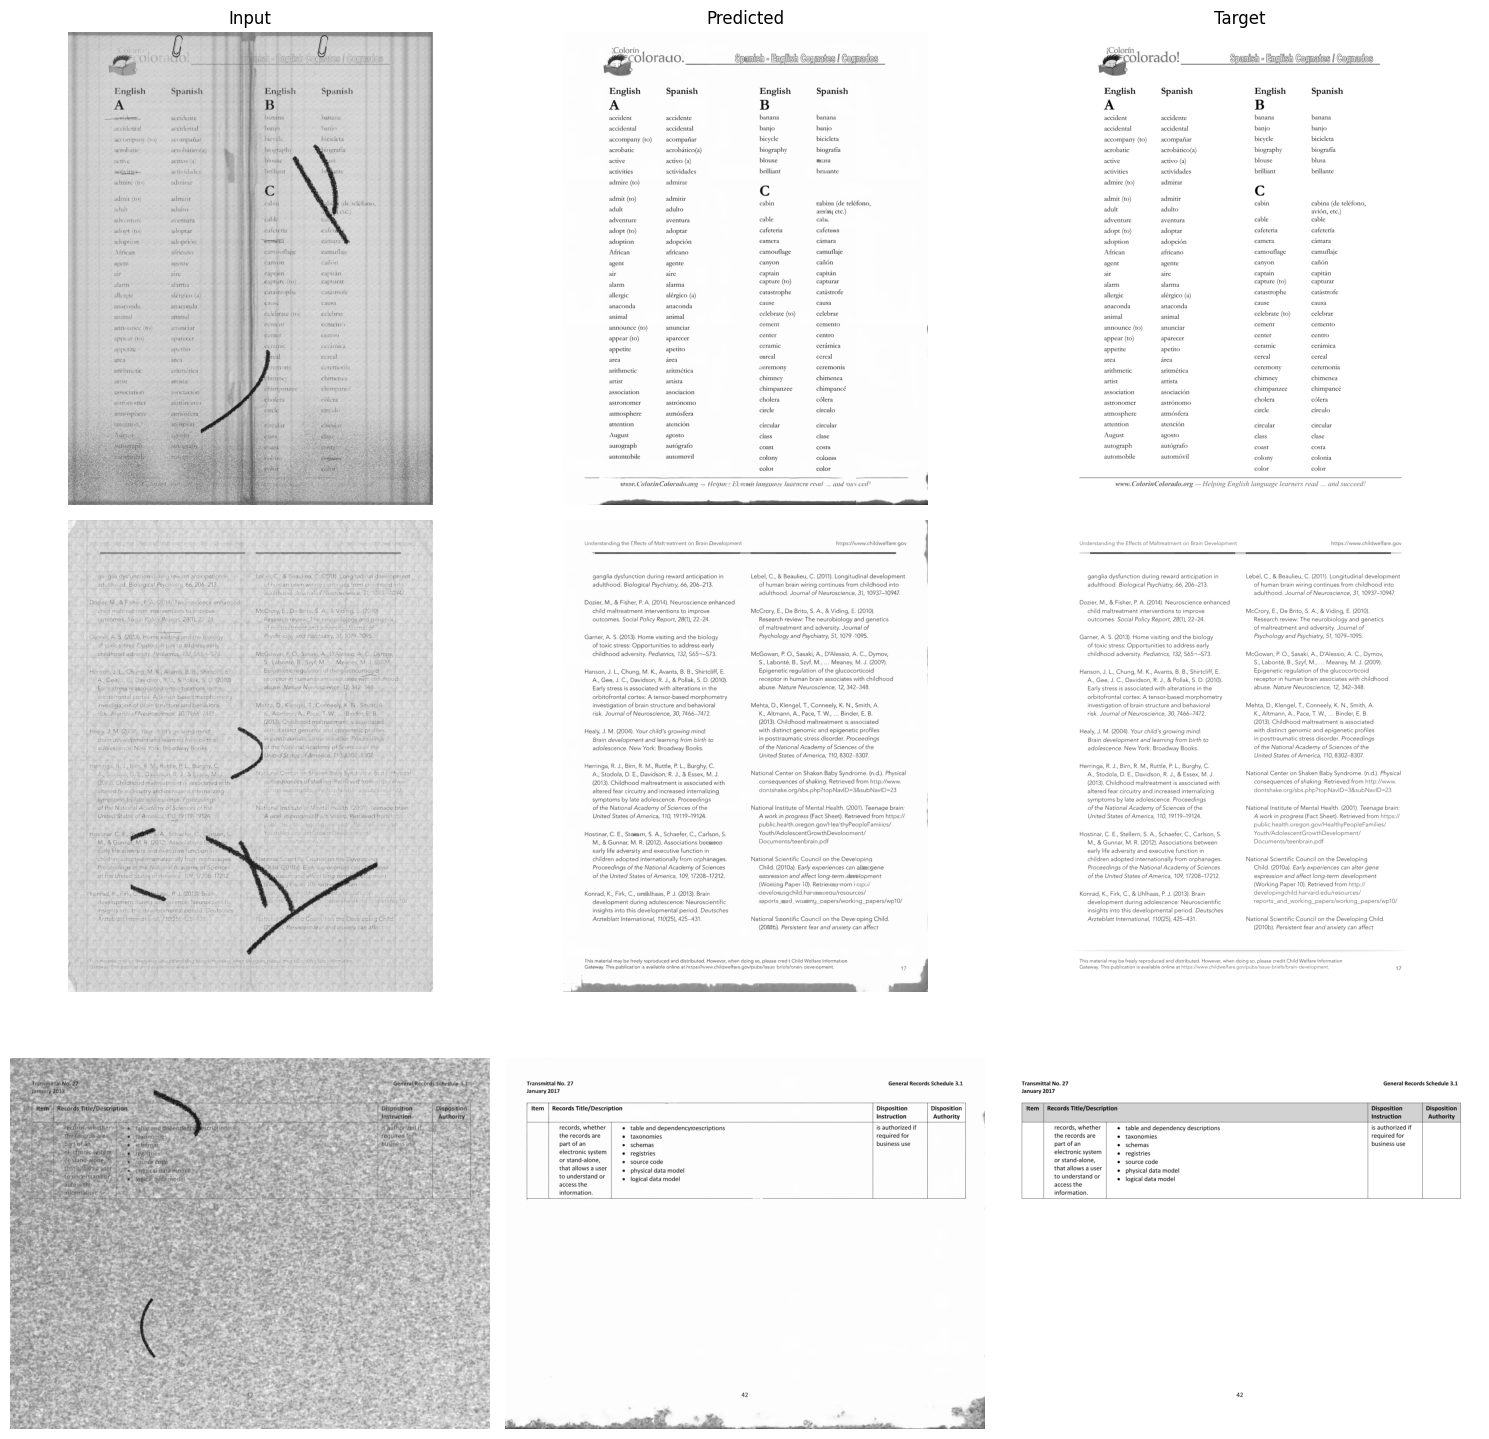

In [ ]:
# Entire Inference Pipeline for predicting on random test images
# The model has not seen these test images
# The steps are shown in the next sub-section

def process_multiple_predictions(test_shabby_img, test_cleaned_img, model, num_samples=3):
    """
    Process multiple image pairs for prediction, reconstruct predictions, and visualize results.
    Args:    test_shabby_img (list of str): input shabby images paths.
             test_cleaned_img (list of str): input cleaned|target images paths.
             model (tf.keras.Model): Trained model for prediction.
             num_samples (int): Number of image pairs to process and display. Default is 3.
    Returns: None
    """

    indices = np.random.choice(len(train_shabby_img), num_samples, replace=False)

    plt.figure(figsize=(15, 5*num_samples))

    for idx, n in enumerate(indices):
        print(f"Processing image pair {n}")

        # Read shabby and clean images
        input_image = cv2.imread(test_shabby_img[n], 0)
        target_image = cv2.imread(test_cleaned_img[n], 0)

        # Split input image into patches
        windows, positions = split_image(input_image, 512, 512)
        patches_array = np.array(windows)
        rows = int(np.ceil(input_image.shape[0] / 512))
        cols = int(np.ceil(input_image.shape[1] / 512))
        patches_array = patches_array.reshape(rows, cols, 512, 512)

        # Get predicted patches
        predicted_patches = []
        for i in range(rows):
            for j in range(cols):
                single_patch = patches_array[i,j] / 255.  # Normalize patch

                # match patch to the expected input shape for most TensorFlow models (e.g., (batch_size, height, width, channels)).
                # (512, 512) --> (512, 512, 1) ---> (1, 512, 512, 1) : (1, height, width, channels)
                single_patch = np.expand_dims(np.expand_dims(single_patch, axis=2), 0) # Add batch and channel dimensions
                prediction = model.predict(single_patch) # Predict patch
                predicted_patches.append(prediction[0,:,:,0]) # Extract prediction

        # Reshape and reconstruct predicted patches
        predicted_patches = np.array(predicted_patches).reshape(rows, cols, 512, 512)
        reconstructed_image = stitch_image(predicted_patches.reshape(-1, 512, 512),
                                         input_image.shape, 512, 512)

        # Plot in grid for input, predicted and target images
        # Shabby input
        plt.subplot(num_samples, 3, idx*3 + 1)
        plt.imshow(input_image/255., cmap='gray', vmin=0, vmax=1)
        plt.title('Input' if idx == 0 else '')
        plt.axis('off')

        # Predicted
        plt.subplot(num_samples, 3, idx*3 + 2)
        plt.imshow(reconstructed_image, cmap='gray', vmin=0, vmax=1)
        plt.title('Predicted' if idx == 0 else '')
        plt.axis('off')

        # Target
        plt.subplot(num_samples, 3, idx*3 + 3)
        plt.imshow(target_image/255., cmap='gray', vmin=0, vmax=1)
        plt.title('Target' if idx == 0 else '')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
process_multiple_predictions(test_shabby_img, test_cleaned_img, model, num_samples=3)

In [ ]:
# NOT WORKING WELL YET
def evaluate_test_set(test_shabby_img, test_cleaned_img, model):
    losses = []

    for idx in range(len(test_shabby_img)):
        print(f"Processing test image {idx+1}/{len(test_shabby_img)}")

        input_image = cv2.imread(test_shabby_img[idx], 0)
        target_image = cv2.imread(test_cleaned_img[idx], 0)

        if target_image.shape != input_image.shape:
            target_image = cv2.resize(target_image, (input_image.shape[1], input_image.shape[0]))

        target_image = target_image.astype('float32') / 255.0

        windows, positions = split_image(input_image, 512, 512)
        patches_array = np.array(windows)
        rows = int(np.ceil(input_image.shape[0] / 512))
        cols = int(np.ceil(input_image.shape[1] / 512))
        patches_array = patches_array.reshape(rows, cols, 512, 512)

        predicted_patches = []
        for i in range(rows):
            for j in range(cols):
                single_patch = patches_array[i,j].astype('float32') / 255.
                single_patch = np.expand_dims(np.expand_dims(single_patch, axis=2), 0)
                prediction = model.predict(single_patch, verbose=0)
                predicted_patches.append(prediction[0,:,:,0])

        predicted_patches = np.array(predicted_patches, dtype='float32').reshape(rows, cols, 512, 512)
        reconstructed_image = stitch_image(predicted_patches.reshape(-1, 512, 512),
                                         input_image.shape, 512, 512)

        y_true = tf.cast(target_image[np.newaxis, ..., np.newaxis], tf.float32)
        y_pred = tf.cast(reconstructed_image[np.newaxis, ..., np.newaxis], tf.float32)

        loss = document_focused_loss(y_true, y_pred)
        losses.append(float(loss))

        if idx % 10 == 0:
            print(f"Current average loss: {np.mean(losses):.4f}")

    return {
        'avg_loss': np.mean(losses),
        'individual_losses': list(zip(test_shabby_img, losses))
    }

# Usage
results = evaluate_test_set(test_shabby_img, test_cleaned_img, model)
print(f"\nAverage Document Focused Loss: {results['avg_loss']:.4f}") # 0.253

#### Individual kernels for patching, predicting, unpatching

In [ ]:
# Process Large image into patches before prediction


import cv2
import numpy as np
import matplotlib.pyplot as plt
def split_image(image, window_height=512, window_width=512):
    h, w = image.shape[:2]
    channels = 1 if len(image.shape) == 2 else image.shape[2]
    windows = []
    positions = []

    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            window = image[y:y+window_height, x:x+window_width]
            if window.shape[0] != window_height or window.shape[1] != window_width:
                pad_h = window_height - window.shape[0]
                pad_w = window_width - window.shape[1]
                window = np.pad(window,
                              ((0, pad_h), (0, pad_w)) if channels == 1 else ((0, pad_h), (0, pad_w), (0, 0)),
                              'constant', constant_values=255)  # Use white padding for document images
            windows.append(window)
            positions.append((y, x))

    return windows, positions

# Read image
large_image = cv2.imread(test_shabby_img[0], 0)

# Split image into patches
windows, positions = split_image(large_image, window_height=512, window_width=512)

# Convert windows list to numpy array for easier handling
patches_array = np.array(windows)
rows = int(np.ceil(large_image.shape[0] / 512))
cols = int(np.ceil(large_image.shape[1] / 512))
patches_array = patches_array.reshape(rows, cols, 512, 512)

print("Large image shape is: ", large_image.shape)
print("Patches array shape is: ", patches_array.shape)

# Display original image
bx = plt.figure(figsize=(9, 9))
bx = plt.imshow(large_image, cmap='gray')
bx = plt.show()

# Display patches
plt.figure(figsize=(9, 9))
ix = 1
for i in range(rows):
    for j in range(cols):
        ax = plt.subplot(rows, cols, ix)
        bx = ax.set_xticks([])
        bx = ax.set_yticks([])
        bx = plt.imshow(patches_array[i, j], cmap='gray')
        ix += 1
plt.show()



Predicting patch 0,0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting patch 0,1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting patch 0,2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicting patch 1,0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting patch 1,1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting patch 1,2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting patch 2,0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting patch 2,1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting patch 2,2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting patch 3,0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting patch 3,1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting patch 3,2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


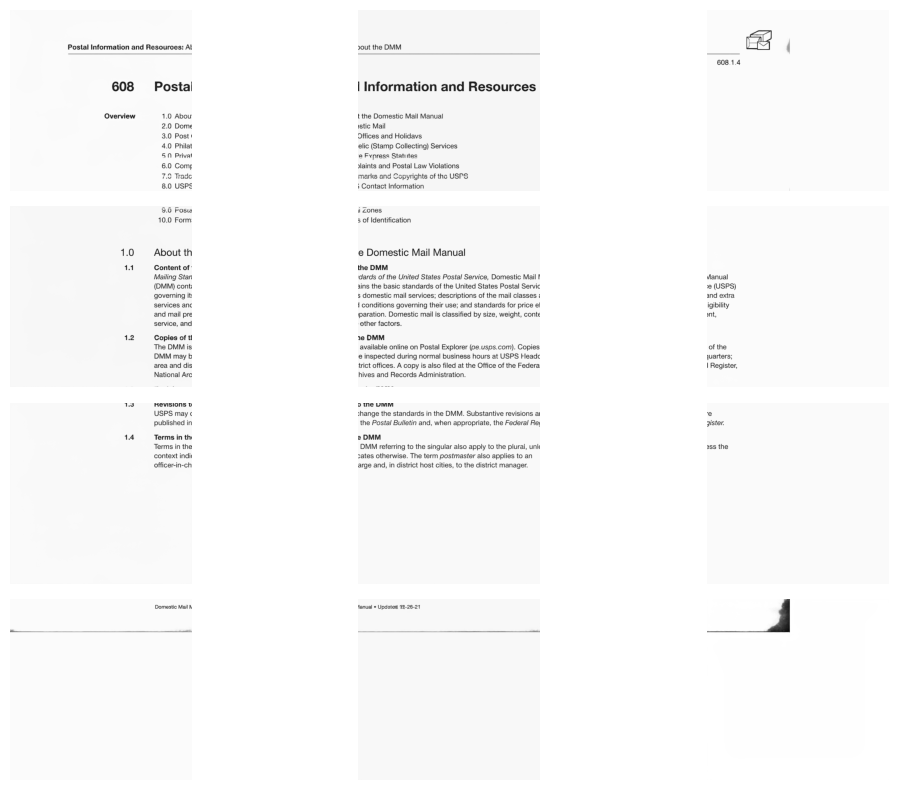

In [ ]:
# Now patch and use for prediction


import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_patches(windows, rows, cols, model):
    predicted_patches = []

    for i in range(rows):
        for j in range(cols):
            print(f"Predicting patch {i},{j}")

            single_patch = patches_array[i,j]
            single_patch = single_patch / 255.
            single_patch = np.expand_dims(single_patch, axis=2)
            single_patch_input = np.expand_dims(single_patch, 0)

            prediction = model.predict(single_patch_input)
            predicted_patch = prediction[0,:,:,0]
            predicted_patches.append(predicted_patch)

    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = predicted_patches.reshape(rows, cols, 512, 512)

    # Display results
    plt.figure(figsize=(12, 8))
    for i in range(rows):
        for j in range(cols):
            ax = plt.subplot(rows, cols, i*cols + j + 1)
            ax = plt.imshow(predicted_patches_reshaped[i, j], cmap='gray')
            ax = plt.axis('off')
    ax = plt.tight_layout()
    ax = plt.show()

    return predicted_patches_reshaped

# Usage with your existing code:
windows, positions = split_image(large_image, window_height=512, window_width=512)
patches_array = np.array(windows)
rows = int(np.ceil(large_image.shape[0] / 512))
cols = int(np.ceil(large_image.shape[1] / 512))
patches_array = patches_array.reshape(rows, cols, 512, 512)

# Run predictions
predicted_patches_reshaped = process_patches(patches_array, rows, cols, model)

<Figure size 1000x1000 with 0 Axes>

(-0.5, 1256.5, 1631.5, -0.5)

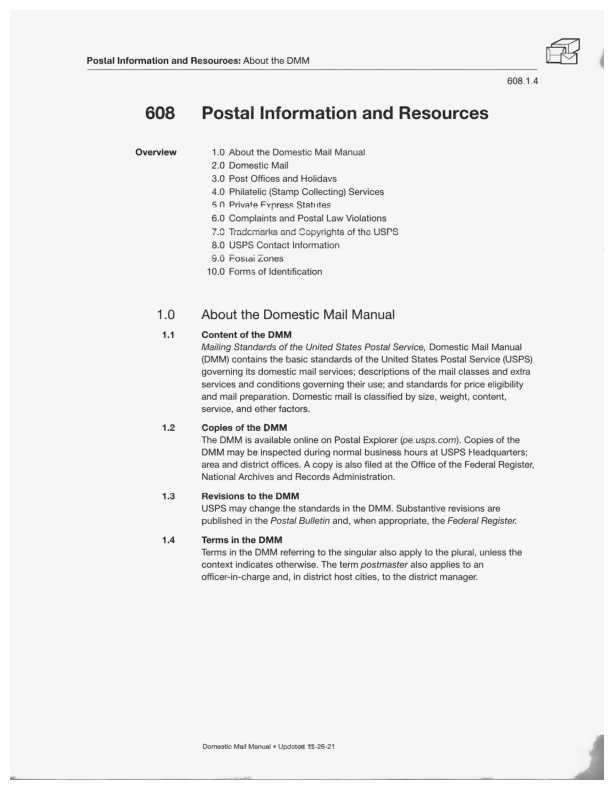

In [ ]:
# Stitch all patches together to reconstruct the images
# The model returns patches as well as predictions.

reconstructed_image = stitch_patches(predicted_patches_reshaped, large_image.shape, 512)

plt.figure(figsize=(10,10))
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


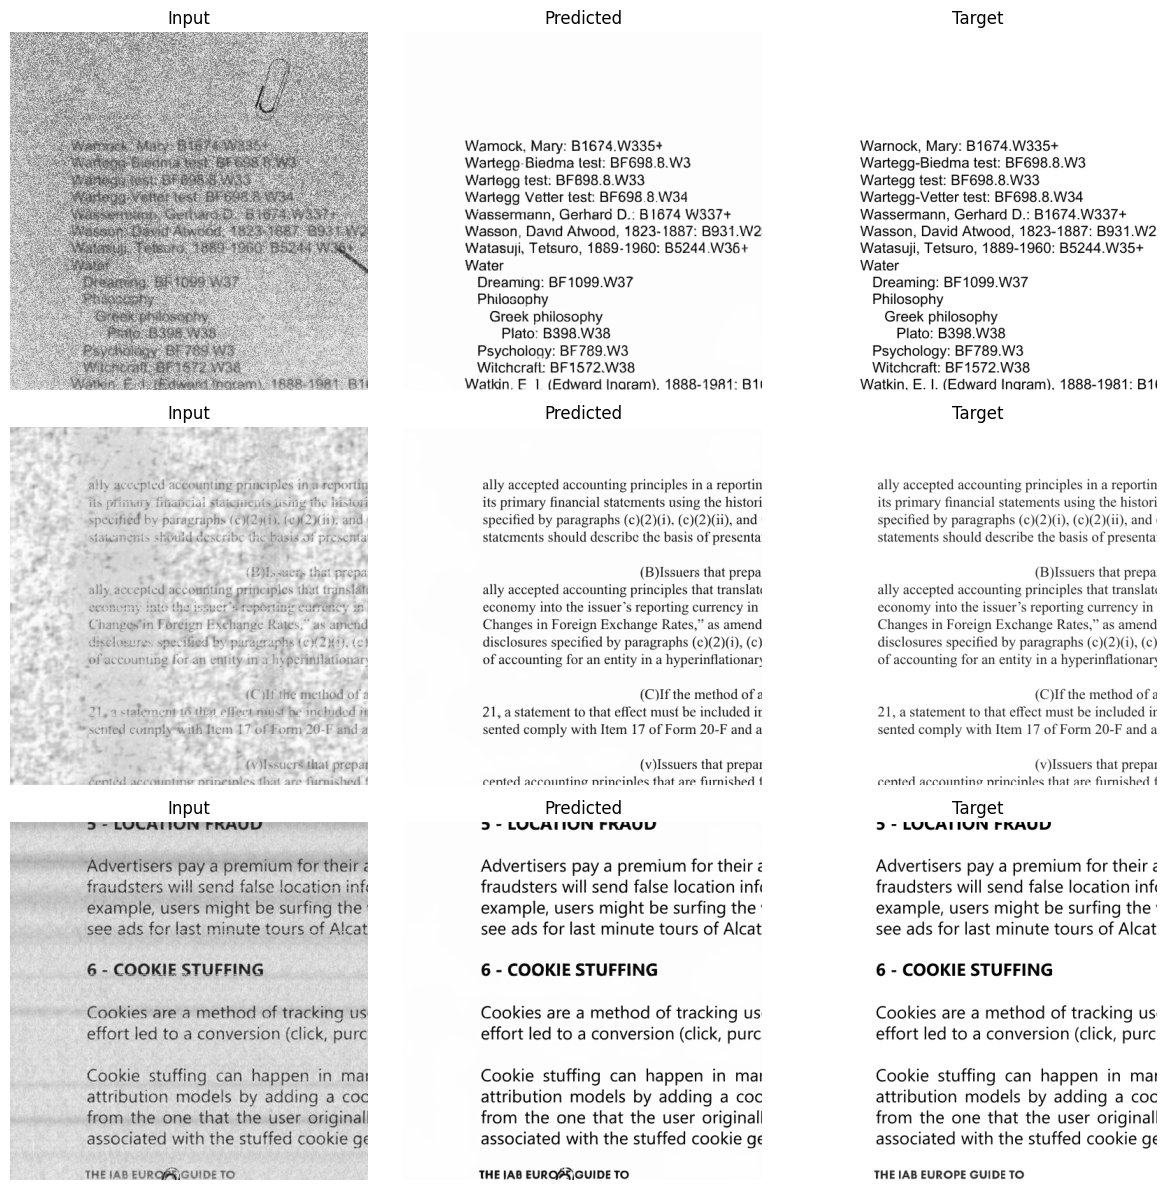

In [ ]:
# Display predictions side by side with shabby image and target clean image


def display_n_images(image_sets, titles=None, n_cols=3):
    n_sets = len(image_sets)
    if titles is None:
        titles = [['Input', 'Predicted', 'Target'] for _ in range(n_sets)]

    plt.figure(figsize=(12, 4*n_sets))
    for row in range(n_sets):
        for col in range(n_cols):
            plt.subplot(n_sets, n_cols, row*n_cols + col + 1)
            plt.imshow(image_sets[row][col].squeeze(), cmap='gray', vmin=0, vmax=1)
            plt.title(titles[row][col])
            plt.axis('off')
    plt.tight_layout()
    plt.show()


def display_predictions(X_val_p, Y_val_p, model, n_samples=3, indices=None):
   if indices is None:
       indices = np.random.choice(len(X_val_p), n_samples, replace=False)

   test_imgs = X_val_p[indices]
   preds = model.predict(test_imgs)

   image_sets = [
       [test_imgs[i], preds[i], Y_val_p[indices[i]]] for i in range(n_samples)
   ]

   titles = [
       ['Input', 'Predicted', 'Target'] for _ in range(n_samples)
   ]

   display_n_images(image_sets, titles)



# Example usage:
display_predictions(X_val_p, Y_val_p, model, n_samples=3, indices=[0,60, 90])
# Or with specific indices:
# display_predictions(X_val_p, Y_val_p, model, indices=[0,5,10])

### H tuning

In [ ]:
# To find best hyperparameters for training


def edge_preservation_loss(y_true, y_pred):
    """Calculate edge preservation loss using Sobel edges."""
    edge_true = tf.image.sobel_edges(y_true)
    edge_pred = tf.image.sobel_edges(y_pred)
    return tf.reduce_mean(tf.abs(edge_true - edge_pred))

def document_focused_loss(y_true, y_pred):
    """Combined loss focusing on structure, edges, and pixel accuracy."""
    ssim_score = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    edge_score = edge_preservation_loss(y_true, y_pred)
    mse_score = tf.keras.losses.mse(y_true, y_pred)

    return 0.6 * ssim_score + 0.3 * edge_score + 0.1 * mse_score



def get_metrics():
   return [
       'mae',
       tf.keras.metrics.MeanSquaredError(name='mse'),
       tf.keras.metrics.Mean(name='edge_preservation')(edge_preservation_loss)
   ]

# Alternative simpler loss function
def combined_ssim_mse_loss(y_true, y_pred):
    """Combine SSIM and MSE losses with weighted average."""
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse = tf.keras.losses.mse(y_true, y_pred)
    return 0.7 * ssim + 0.3 * mse

# Your existing model code
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def combined_loss(y_true, y_pred):
    ssim = ssim_loss(y_true, y_pred)
    mse = tf.keras.losses.mse(y_true, y_pred)
    return 0.7 * ssim + 0.3 * mse


In [ ]:
# Hyperparameter Configuration
# Parameter	Possible Values	Description
# input_size	          ---> [128, 256, 512]	The size of the input images.
# initial_filters	      ---> [32, 64]	The number of filters in the initial convolutional layer.
# depth	                ---> Integers from 3 to 10 (inclusive)	The depth of the network, representing the number of layers or blocks.
# block_depth	          ---> Integers from 2 to 4 (inclusive)	The depth of each block within the network.
# widths_multiplier	    ---> Floats between 1.5 and 2.0	A multiplier to adjust the widths (number of filters) across layers or blocks.
# dropout_rate          --->	Floats between 0.0 and 0.5	The dropout rate used to prevent overfitting.
# batch_size	          ---> [2, 4, 8]	The number of samples processed before the model is updated.
# learning_rate         --->	Continuous values between 1e-5 and 1e-3 (log scale)	The step size at each iteration while moving toward a minimum of a loss function.

In [ ]:
import json
import os
import tensorflow as tf
import gc
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.mixed_precision import set_global_policy

try:
  import optuna
except ImportError:
  !pip install -qU optuna
  import optuna
from optuna.trial import Trial


set_global_policy('mixed_float16')

import tensorflow as tf


def save_study_results(study, phase_number):
    results = {
        'best_params': study.best_params,
        'best_value': study.best_value,
        'phase': phase_number
    }
    os.makedirs('unet_optimization_results', exist_ok=True)
    with open(f'unet_optimization_results/phase_{phase_number}_results.json', 'w') as f:
        json.dump(results, f)

def load_previous_results():
    results = []
    results_dir = 'unet_optimization_results'
    if os.path.exists(results_dir):
        for file in os.listdir(results_dir):
            if file.endswith('_results.json'):
                with open(os.path.join(results_dir, file), 'r') as f:
                    results.append(json.load(f))
    return sorted(results, key=lambda x: x['phase'])

def create_search_space(trial: Trial):
    params = {
        'input_size': 512, #trial.suggest_categorical('input_size', [128, 256, 512]),
        'initial_filters': 32, #trial.suggest_categorical('initial_filters', [32, 64]),
        'depth': 8, #trial.suggest_int('depth', 3, 10),
        'block_depth': 4, #trial.suggest_int('block_depth', 2, 4),
        'widths_multiplier': 2, #trial.suggest_float('widths_multiplier', 1.5, 2.0),
        'dropout_rate': 0.5, #trial.suggest_float('dropout_rate', 0.0, 0.5),
        'batch_size': 4, #trial.suggest_categorical('batch_size', [2, 4, 8]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
    }
    return params

def create_informed_search_space(trial: Trial, previous_results):
    if previous_results:
        best_previous = min(previous_results, key=lambda x: x['best_value'])
        best_params = best_previous['best_params']

        params = {
            'input_size': 512, # trial.suggest_categorical('input_size', [best_params['input_size']]),
            'initial_filters': 32,  #trial.suggest_categorical('initial_filters', [max(32, int(best_params['initial_filters'] * 0.8)), best_params['initial_filters'], min(128, int(best_params['initial_filters'] * 1.2))]),
            'depth': 8, # trial.suggest_int('depth', max(3, best_params['depth'] - 1), (5, best_params['depth'] + 1)),
            'block_depth': 4, #trial.suggest_int('block_depth', max(2, best_params['block_depth'] - 1), min(4, best_params['block_depth'] + 1)),
            'widths_multiplier': 2, #trial.suggest_float('widths_multiplier', max(1.5, best_params['widths_multiplier'] * 0.9), min(2.5, best_params['widths_multiplier'] * 1.1)),
            'dropout_rate': 0.5, #trial.suggest_float('dropout_rate', max(0.0, best_params['dropout_rate'] - 0.1), min(0.5, best_params['dropout_rate'] + 0.1)),
            'batch_size': 4, #trial.suggest_categorical('batch_size', [best_params['batch_size']]),

            'learning_rate': trial.suggest_float('learning_rate',
                best_params['learning_rate'] * 0.5,
                best_params['learning_rate'] * 2,
                log=True),
        }
    else:
        params = create_search_space(trial)
    return params

def objective(trial: Trial, params, EPOCHS, X_train_p, Y_train_p, X_val_p, Y_val_p):
    gc.collect()
    try:
        tf.keras.backend.clear_session()
    except AssertionError:
        print("Skipping clear_session due to nested graph context.")

    # Reset GPU memory
    tf.config.experimental.reset_memory_stats('GPU:0')

    try:
        with tf.device('/GPU:0'):
            model = get_network(params)


            history = model.fit(
                X_train_p, Y_train_p,
                batch_size=params['batch_size'],
                epochs=EPOCHS,
                validation_data=(X_val_p, Y_val_p),
                callbacks=[EarlyStoppingCallback(), PruningCallback(trial)],
                verbose=1
            )

            score = min(history.history['val_loss'])

            del model
            tf.keras.backend.clear_session()
            gc.collect()

            return score

    except Exception as e:
        tf.keras.backend.clear_session()
        gc.collect()
        raise optuna.TrialPruned(f"Trial failed: {str(e)}")

def run_optimization_phase(phase_number, epoch_params, X_train_p, Y_train_p, X_val_p, Y_val_p):
    NUM_TRIALS = epoch_params['NUM_TRIALS']
    NUM_STARTUP_TRIALS = epoch_params['NUM_STARTUP_TRIALS']
    EPOCHS = epoch_params['EPOCHS']

    previous_results = load_previous_results()

    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=NUM_STARTUP_TRIALS,
            n_warmup_steps=3,
            interval_steps=2
        )
    )

    def phase_objective(trial):
        params = create_informed_search_space(trial, previous_results)
        return objective(trial, params, EPOCHS, X_train_p, Y_train_p, X_val_p, Y_val_p)

    study.optimize(
        phase_objective,
        n_trials=NUM_TRIALS,
        gc_after_trial=True
    )

    save_study_results(study, phase_number)
    return study

# Example usage:
epoch_params = {
    'NUM_TRIALS': 2,
    'NUM_STARTUP_TRIALS': 2,
    'EPOCHS': 2
}

# Run multiple phases
def run_tuning(X_train_p, Y_train_p, X_val_p, Y_val_p, start_phase=0, num_phases=3):
    for phase in range(start_phase, start_phase + num_phases):
        print(f"Starting optimization phase {phase + 1}")
        gc.collect()

        try:
            tf.keras.backend.clear_session()
        except AssertionError:
            print("Skipping clear_session due to nested graph context.")

        study = run_optimization_phase(phase + 1, epoch_params, X_train_p, Y_train_p, X_val_p, Y_val_p)

        print(f"Phase {phase + 1} complete")
        print(f"Best value: {study.best_trial.value}")
        print(f"Best parameters: {study.best_trial.params}")

# run_tuning(X_train_p, Y_train_p, X_val_p, Y_val_p, start_phase=0, num_phases=1)

In [ ]:
run_tuning(X_train_p, Y_train_p, X_val_p, Y_val_p, start_phase=0, num_phases=1)

Starting optimization phase 1


[I 2024-12-12 12:50:19,704] A new study created in memory with name: no-name-476d9d24-5e70-4307-93e1-3245e9e610e0
[I 2024-12-12 12:50:38,292] Trial 0 pruned. Trial failed: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.
[I 2024-12-12 12:50:51,049] Trial 1 pruned. Trial failed: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 


ValueError: No trials are completed yet.

### Denoiser with median filtering

In [ ]:
!ls {denoising_autoencoder_pcx_dir}

# # # For models saved with .keras extension
from tensorflow.keras.models import load_model
model_path = f'{denoising_autoencoder_pcx_dir}/best_enhanced_autoencoder_v2.keras'

model = load_model(model_path, custom_objects={'ssim_loss': ssim_loss})

# # # For older .h5 files
# # # model = load_model('model_path.h5', custom_objects={'ssim_loss': ssim_loss})



best_enhanced_autoencoder_7_15.keras  best_enhanced_autoencoder_v2.keras


In [ ]:
# for pdf_files instead of png_files

import os
import cv2
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from glob import glob
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import fitz  # PyMuPDF
from scipy import signal
from PIL import Image

# Load the pre-trained denoiser model
# model = load_model(f'{denoising_autoencoder_pcx_dir}/best_enhanced_autoencoder_7_15.h5')

# raise SystemExit

# Define the task and directories
print(shabby01_path)

input_dir = "/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/prob_imgs" #'/content/gdrive/MyDrive/Image Extraction/imageextraction/bulk_papers/dataset/problematic_pdfs'
out_dir = "/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/denoising_autoencoder_output" #'/content/gdrive/MyDrive/Image Extraction/denoised_test/autoencoder'
os.makedirs(out_dir, exist_ok=True)

# raise SystemExit

# Model input size
input_height = 512
input_width = 512

# Utility function to split the image into smaller windows
def split_image(image, window_height, window_width):
    h, w = image.shape[:2]
    channels = 1 if len(image.shape) == 2 else image.shape[2]
    windows = []
    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            window = image[y:y+window_height, x:x+window_width]
            if window.shape[0] != window_height or window.shape[1] != window_width:
                pad_h = window_height - window.shape[0]
                pad_w = window_width - window.shape[1]
                if channels == 1:
                    window = np.pad(window, ((0, pad_h), (0, pad_w)), 'constant', constant_values=0)
                else:
                    window = np.pad(window, ((0, pad_h), (0, pad_w), (0, 0)), 'constant', constant_values=0)
            windows.append(window)
    return windows

# Utility function to stitch the image back together from smaller windows
def stitch_image(windows, original_shape, window_height, window_width):
    h, w = original_shape[:2]
    channels = 1 if len(windows[0].shape) == 2 else windows[0].shape[2]
    stitched_image = np.zeros((h, w, channels), dtype=np.uint8)
    i = 0
    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            stitched_image[y:y+window_height, x:x+window_width] = windows[i][:min(window_height, h - y), :min(window_width, w - x)]
            i += 1
    return stitched_image

# Background removal function
def denoise_image(inp):
    # estimate 'background' color by a median filter
    bg = signal.medfilt2d(inp, 11)

    # compute 'foreground' mask as anything that is significantly darker than the background
    mask = inp < bg - 0.1

    # return the input value for all pixels in the mask or pure white otherwise
    return np.where(mask, inp, 1.0)

# Process each PDF in the input directory
pdf_files = natsorted(glob(os.path.join(input_dir, '*.pdf')))

for pdf_path in tqdm(pdf_files, desc="Processing PDFs"):
    document = fitz.open(pdf_path)
    pdf_filename = os.path.splitext(os.path.basename(pdf_path))[0]

    for page_num in range(len(document)):
        page = document.load_page(page_num)
        # Render page to an image
        pix = page.get_pixmap()
        image = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)

        if pix.n == 4:  # Convert RGBA to RGB
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

        original_shape = image.shape
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # split image into windows
        windows = split_image(gray_img, input_height, input_width)

        restored_windows = []
        for window in windows:
            input_tensor = np.expand_dims(window, axis=0).astype(np.float32) / 255.0
            input_tensor = np.expand_dims(input_tensor, axis=-1)  # Add channel dimension

            # Denoise the window
            restored_tensor = model.predict(input_tensor)
            restored_image = np.squeeze(restored_tensor, axis=0) * 255.0
            restored_image = restored_image.astype(np.uint8)
            restored_windows.append(cv2.cvtColor(restored_image, cv2.COLOR_GRAY2RGB))  # Convert back to RGB

        # Stitch the windows back together
        restored_img = stitch_image(restored_windows, original_shape, input_height, input_width)

        # Background removal
        restored_img_gray = cv2.cvtColor(restored_img, cv2.COLOR_RGB2GRAY)
        restored_img_denoised = denoise_image(restored_img_gray / 255.0)
        restored_img_denoised = (restored_img_denoised * 255).astype(np.uint8)

        # Save the restored image without background
        img_filename = f"{pdf_filename}_page{page_num+1}.png"
        cv2.imwrite(os.path.join(out_dir, img_filename), restored_img_denoised)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Denoised and Background Removed Image')
        plt.imshow(restored_img_denoised, cmap='gray')
        plt.axis('off')

        plt.show()


/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/


Processing PDFs: 0it [00:00, ?it/s]


/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/shabby01/shabby/


Processing Images:   0%|          | 0/1 [00:00<?, ?it/s]

Input tensor shape: (1, 512, 512, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Restored tensor shape: (1, 512, 512, 1)
Restored tensor min/max: 0.526, 0.568
Window min/max: 255.000, 255.000
Restored image min/max: 134, 144
Input tensor shape: (1, 512, 512, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Restored tensor shape: (1, 512, 512, 1)
Restored tensor min/max: 0.526, 0.568
Window min/max: 255.000, 255.000
Restored image min/max: 134, 144
Input tensor shape: (1, 512, 512, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Restored tensor shape: (1, 512, 512, 1)
Restored tensor min/max: 0.526, 0.568
Window min/max: 255.000, 255.000
Restored image min/max: 134, 144
Input tensor shape: (1, 512, 512, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Restored tensor shape: (1, 512, 512, 1)
Restored tensor min/max: 0.526, 0.568
Window min/max: 255.000, 255.000
Restored image min/max: 134, 144
Input tensor shape: (1, 512, 512, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Restored tensor shape: (1, 512, 512, 1)
Restored te

True

<Figure size 1200x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Original Image')

(-0.5, 4249.5, 5499.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Denoised and Background Removed Image')

(-0.5, 4249.5, 5499.5, -0.5)

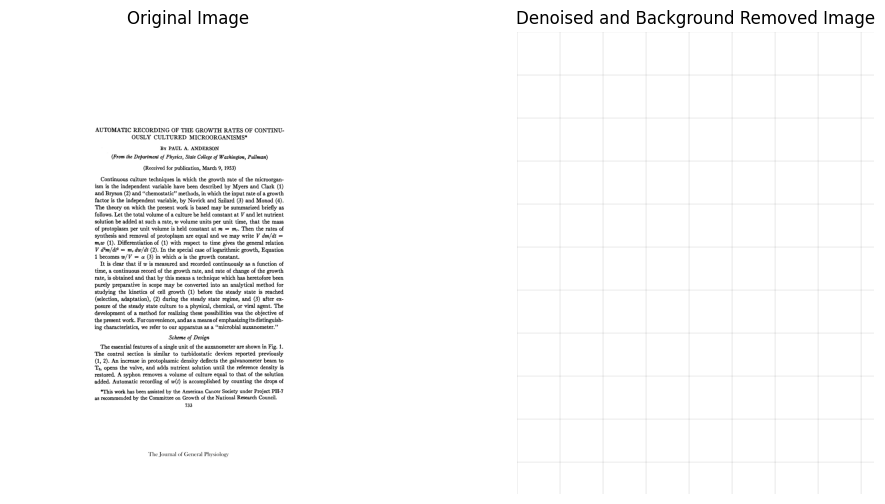

Processing Images: 100%|██████████| 1/1 [00:16<00:00, 16.35s/it]


In [ ]:
# for PNG instead of PDF files

import os
import cv2
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from glob import glob
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import fitz  # PyMuPDF
from scipy import signal
from PIL import Image

# Load the pre-trained denoiser model
# model = load_model(f'{denoising_autoencoder_pcx_dir}/best_enhanced_autoencoder_7_15.h5')

# raise SystemExit

# Define the task and directories
print(shabby01_path)

input_dir = "/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/prob_imgs" #'/content/gdrive/MyDrive/Image Extraction/imageextraction/bulk_papers/dataset/problematic_pdfs'
out_dir = "/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/denoising_autoencoder_output" #'/content/gdrive/MyDrive/Image Extraction/denoised_test/autoencoder'
os.makedirs(out_dir, exist_ok=True)

# raise SystemExit

# Model input size
input_height = 512
input_width = 512

# Utility function to split the image into smaller windows
def split_image(image, window_height, window_width):
    h, w = image.shape[:2]
    channels = 1 if len(image.shape) == 2 else image.shape[2]
    windows = []
    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            window = image[y:y+window_height, x:x+window_width]
            if window.shape[0] != window_height or window.shape[1] != window_width:
                pad_h = window_height - window.shape[0]
                pad_w = window_width - window.shape[1]
                if channels == 1:
                    window = np.pad(window, ((0, pad_h), (0, pad_w)), 'constant', constant_values=0)
                else:
                    window = np.pad(window, ((0, pad_h), (0, pad_w), (0, 0)), 'constant', constant_values=0)
            windows.append(window)
    return windows

# Utility function to stitch the image back together from smaller windows
def stitch_image(windows, original_shape, window_height, window_width):
    h, w = original_shape[:2]
    channels = 1 if len(windows[0].shape) == 2 else windows[0].shape[2]
    stitched_image = np.zeros((h, w, channels), dtype=np.uint8)
    i = 0
    for y in range(0, h, window_height):
        for x in range(0, w, window_width):
            stitched_image[y:y+window_height, x:x+window_width] = windows[i][:min(window_height, h - y), :min(window_width, w - x)]
            i += 1
    return stitched_image

# Background removal function
def denoise_image(inp):
    # estimate 'background' color by a median filter
    bg = signal.medfilt2d(inp, 11)

    # compute 'foreground' mask as anything that is significantly darker than the background
    mask = inp < bg - 0.05  # Reduced from 0.1

    # return the input value for all pixels in the mask or pure white otherwise
    return np.where(mask, inp, 1.0)

png_files = natsorted(glob(os.path.join(input_dir, '*.png')))[:1]

for img_path in tqdm(png_files, desc="Processing Images"):
   # Read image directly
   image = cv2.imread(img_path)
   filename = os.path.splitext(os.path.basename(img_path))[0]

   original_shape = image.shape
   gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   windows = split_image(gray_img, input_height, input_width)

   restored_windows = []
   for window in windows:
       input_tensor = np.expand_dims(window, axis=0).astype(np.float32) / 255.0
       input_tensor = np.expand_dims(input_tensor, axis=-1)  # Add channel dimension
       print(f"Input tensor shape: {input_tensor.shape}")

       # Denoise the window
       restored_tensor = model.predict(input_tensor)
       print(f"Restored tensor shape: {restored_tensor.shape}")
       print(f"Restored tensor min/max: {restored_tensor.min():.3f}, {restored_tensor.max():.3f}")
       print(f"Window min/max: {window.min():.3f}, {window.max():.3f}")

       restored_image = np.squeeze(restored_tensor, axis=0) * 255.0
       restored_image = restored_image.astype(np.uint8)
       print(f"Restored image min/max: {restored_image.min()}, {restored_image.max()}")

       restored_windows.append(restored_image)

   # Stitch the windows back together
   restored_img = stitch_image(restored_windows, original_shape, input_height, input_width)

  #  # Background removal
  #  restored_img_gray = cv2.cvtColor(restored_img, cv2.COLOR_RGB2GRAY)
  #  restored_img_denoised = denoise_image(restored_img_gray / 255.0)
  #  restored_img_denoised = (restored_img_denoised * 255).astype(np.uint8)

   # Save the restored image
   img_filename = f"{filename}_denoised.png"
  #  cv2.imwrite(os.path.join(out_dir, img_filename), restored_img_denoised)
   cv2.imwrite(os.path.join(out_dir, img_filename), restored_img)

   # Display results
   plt.figure(figsize=(12, 6))
   plt.subplot(1, 2, 1)
   plt.title('Original Image')
   plt.imshow(image)
   plt.axis('off')

   plt.subplot(1, 2, 2)
   plt.title('Denoised and Background Removed Image')
   plt.imshow(restored_img, cmap='gray')
  #  plt.imshow(restored_img_denoised, cmap='gray')
   plt.axis('off')
   plt.show()